Reconstruction is decent and Basis Actually make sense for. 

In [ ]:
import numpy as np, torch
import scipy.stats as st
import itertools
from DecompTCR.tools._basis_decomposition.run_batch import compute_basis_decomposition, _plot_basis, get_basis
from DecompTCR.tools._basis_decomposition.inference  import InferenceMode
from pyro.infer import Predictive, TraceEnum_ELBO
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import pandas as pd
import pickle
import os
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
import datetime
from sklearn.preprocessing import LabelEncoder
from umap import UMAP

import pyro

from sklearn.neighbors import kneighbors_graph
from sknetwork.clustering import Louvain
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.model_selection import train_test_split


from tools._basis_decomposition.inference import get_inference_guide
from tools._basis_decomposition.model_batch import BasisDecomposition, BasisDecomposition_Evaluate
from pyro.infer import Predictive, SVI, Trace_ELBO, TraceTMC_ELBO





In [67]:
def display_cat(lut, figsize = (3,4), vertical = True, title = "", title_x_offset = -4):
    n_boxes = len(lut)
    
    labels = list(lut.keys())
    
    fig, ax = plt.subplots(figsize = figsize)

    ax.set_aspect('equal')
    ax.set_title(title, loc = "left", x = title_x_offset)
    if vertical:
        start_y = 0
        for key in labels:
            ax.add_patch(plt.Rectangle((0, start_y), 1, 1, facecolor=lut[key]))
            start_y += 1.5
        
        ylim = [-0.5, 1.5*len(lut)]
        ax.set_ylim(ylim)
        ax.set_xlim([0, 1])

        yticks = np.arange(0.5,0.5+len(lut)*1.5, 1.5)
        ax.set_yticks(yticks)
        ax.set_yticklabels(labels)
        
        ax.tick_params(axis='y', which='both', bottom=False, top=False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    else:
        start_x = 0
        for key in labels:
            ax.add_patch(plt.Rectangle((start_x, 0), 1, 1, facecolor=lut[key]))
            start_x += 1.5
            
        xlim = [-0.5, 1.5*len(lut)]
        ax.set_xlim(xlim)
        ax.set_ylim([0, 1])

        xticks = np.arange(0.5,0.5+len(lut)*1.5, 1.5)
        ax.set_xticks(xticks)
        ax.set_xticklabels(labels, rotation = 90)
        
        ax.tick_params(axis='x', which='both', bottom=False, top=False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_yticks([])
        ax.set_yticklabels([])
        

    



    
    # Show the plot
    plt.close()
    return(ax)

# lut = dict(zip(np.unique(ptcy), sns.color_palette("tab20")))
# display_cat(lut, figsize = (1,.4), vertical = True, title = "Test")


In [68]:
def clear_val_params():
    keys_to_delete = keys_to_delete = [key for key in pyro.get_param_store().keys() if "val" in key]
    for key in keys_to_delete:
        del pyro.get_param_store()[key]

In [69]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "values": v,
        }
    return site_stats

In [70]:
#This is purely for figure generating the
sin_f = np.sin(np.linspace(0, 6.28, 181)*2)+1
inc_f = 1*np.linspace(0,1,181)
dec_f = -1*np.linspace(0,1,181)+1
sigp_f = 1/(1 + np.exp(-np.linspace(-10,20,181))) 
sign_f = -1/(1 + np.exp(-np.linspace(-5,20,181))) + 1 

sin_f = (sin_f - np.min(sin_f))/np.max(sin_f)
sigp_f = (sigp_f - np.min(sigp_f))/np.max(sigp_f) 
sign_f = (sign_f - np.min(sign_f))/np.max(sign_f)

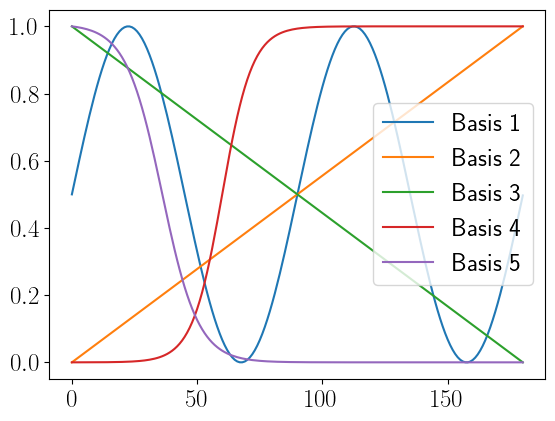

In [71]:
plt.plot(sin_f)
plt.plot(inc_f)
plt.plot(dec_f)
plt.plot(sigp_f)
plt.plot(sign_f)
plt.legend(["Basis 1", "Basis 2", "Basis 3", "Basis 4", "Basis 5"])

In [72]:
random_weights = np.random.dirichlet((0.5, 0.5, 0.5, 0.5, 0.5), 10000)

In [73]:
new_functions = [random_weights[i,0]*sin_f + random_weights[i,1]*inc_f + random_weights[i,2]*dec_f + random_weights[i,3]*sigp_f + random_weights[i,4]*sign_f for i in range(len(random_weights[:,0]))] 

In [74]:
new_functions = np.array(new_functions)

In [75]:
def bernoulli_downsample(data, p_start, p_end):
    """
    Downsample timepoints in a NumPy array using Bernoulli sampling,
    with decreasing probability for later timepoints. Replace downsampled
    points with NaN values.
    
    Parameters:
    data (np.ndarray): Input array with shape (n_samples, n_timepoints)
    p_start (float): Starting probability of keeping a timepoint (0 < p_start <= 1)
    p_end (float): Ending probability of keeping a timepoint (0 < p_end <= p_start)
    
    Returns:
    np.ndarray: Downsampled array with NaN values
    """
    n_samples, n_timepoints = data.shape
    
    # Create a linearly decreasing probability array
    p_array = np.linspace(p_start, p_end, n_timepoints)
    
    # Create a Bernoulli mask with decreasing probability
    mask = np.random.binomial(1, p_array, size=(n_samples, n_timepoints))
    
    # Ensure at least one timepoint is kept for each sample
    for i in range(n_samples):
        if np.sum(mask[i]) == 0:
            mask[i, np.random.randint(0, n_timepoints)] = 1
    
    # Create a copy of the data and replace masked values with NaN
    downsampled = data.astype(float)  # Convert to float to support NaN
    downsampled[mask == 0] = np.nan
    
    return downsampled

In [76]:
new_functions_ds = bernoulli_downsample(new_functions, 0.05, 0.001)

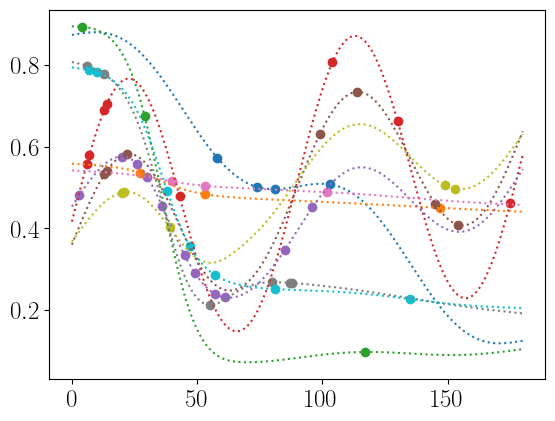

In [77]:
for i in range(10):
    plt.scatter(np.arange(0,181,1),new_functions_ds[i,:])
    plt.plot(np.arange(0,181,1), new_functions[i,:], linestyle = ":")

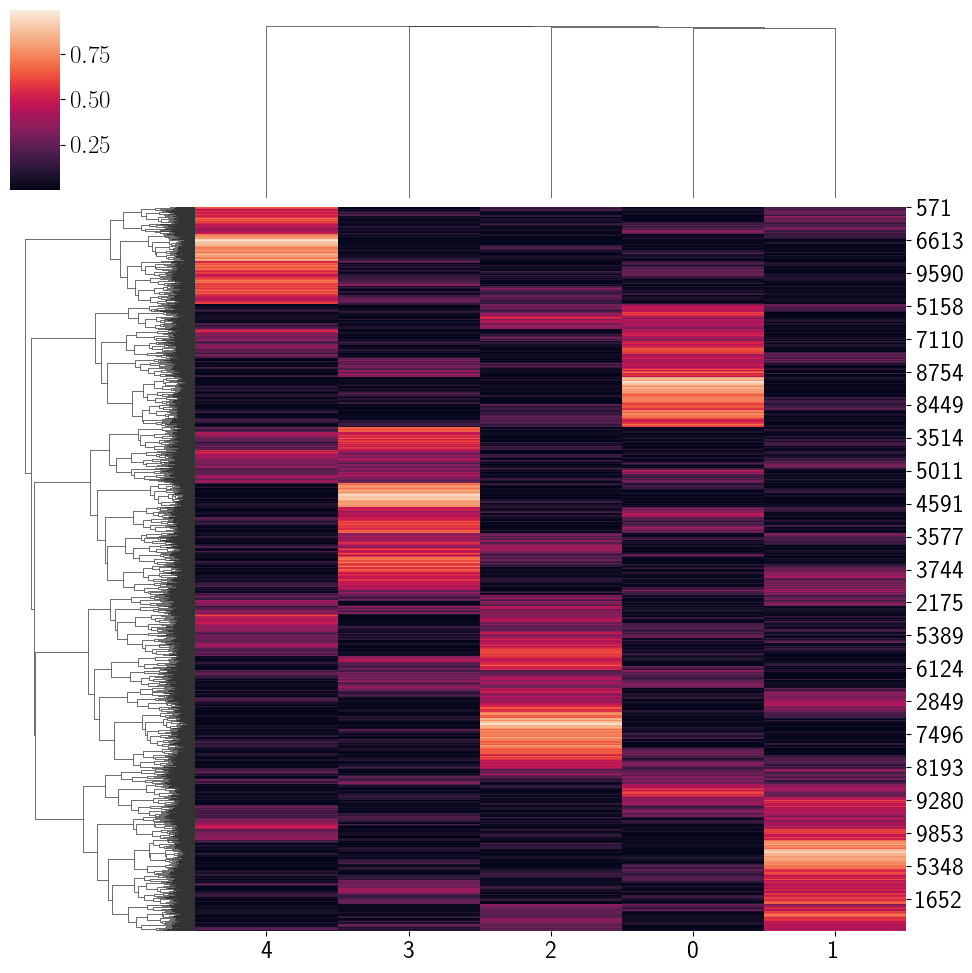

In [78]:
sns.clustermap(random_weights)

In [79]:
new_functions_ds = torch.FloatTensor(new_functions_ds)

train_a_idx, val_a_idx = train_test_split(np.arange(new_functions_ds.shape[0]), test_size = 0.1)
gene_patterns_padded_allo_train = new_functions_ds[train_a_idx,:]
gene_patterns_padded_allo_val = new_functions_ds[val_a_idx,:]




In [80]:
gt = torch.FloatTensor(new_functions)
gt_train = gt[train_a_idx,:]
gt_val = gt[val_a_idx,:]

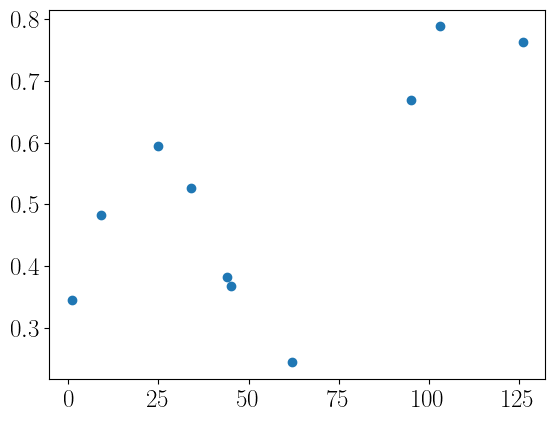

In [81]:
plt.scatter(np.arange(0,181,1),gene_patterns_padded_allo_train[10,:])

In [82]:
#allo needs very different parameters
n_basis = 5
n_iter = 2_000
show_basis = False
lr = 1e-2
beta_prior = 0.001
weight_decay = 1e-7
inverse_length_scale = 6
times_padded = np.linspace(-1,1,181)

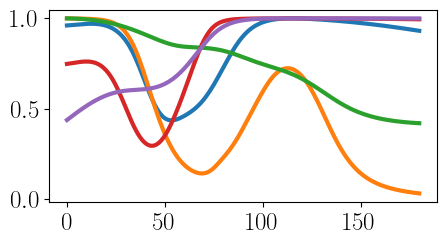

Loss: 157717.5 - Relative Error: 0.05, - Val_loss: 0.05: 100%|██████████| 2000/2000 [1:37:05<00:00,  2.91s/it]


In [83]:



trajectory_model_a, guide_a, times_a, samples_a, gene_scales_a, losses_a, rel_loss_a, val_loss_a = compute_basis_decomposition(
gene_patterns_padded_allo_train.numpy(),#gene_patterns_masked,#gene_patterns_padded,
InferenceMode.GAUSSIAN_BETA_ONLY,#POINT_ESTIMATE,
n_basis=n_basis,
n_iter=n_iter,
batch_size=None,
#show_basis=show_basis,
lr=lr,
beta_prior=beta_prior,
weight_decay = weight_decay,
inverse_length_scale = inverse_length_scale,
seed=1,
normalized_mode=True,
times = np.linspace(-1,1,181),
plot_every_k_epochs=100,
clone_patterns_val= gene_patterns_padded_allo_val.numpy()
) 



In [84]:
gen_patterns_mean = gene_patterns_padded_allo_train.nanmean(axis = -1, keepdim= True)
print(trajectory_model_a.gene_scales.detach().shape)
print((trajectory_model_a.gene_scales.detach() * gen_patterns_mean))

torch.Size([9000, 1])
tensor([[0.7254],
        [0.4877],
        [0.8299],
        ...,
        [0.6901],
        [0.7323],
        [0.6191]])


In [85]:
gene_scales_a.shape

torch.Size([9000, 1])

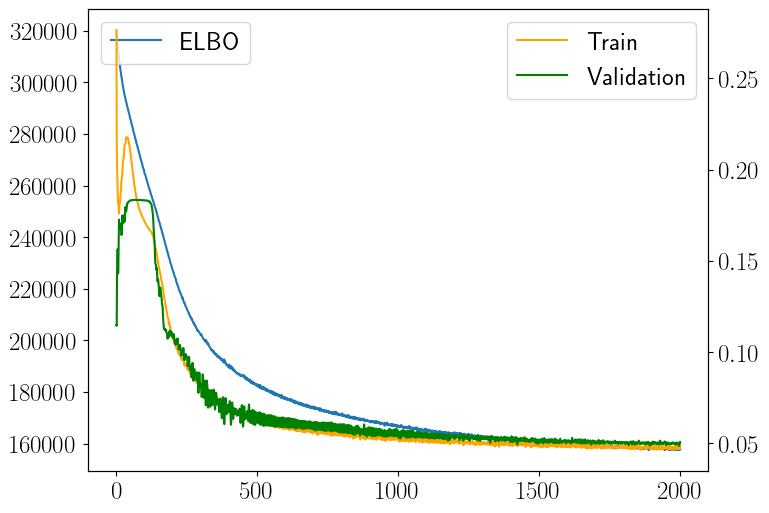

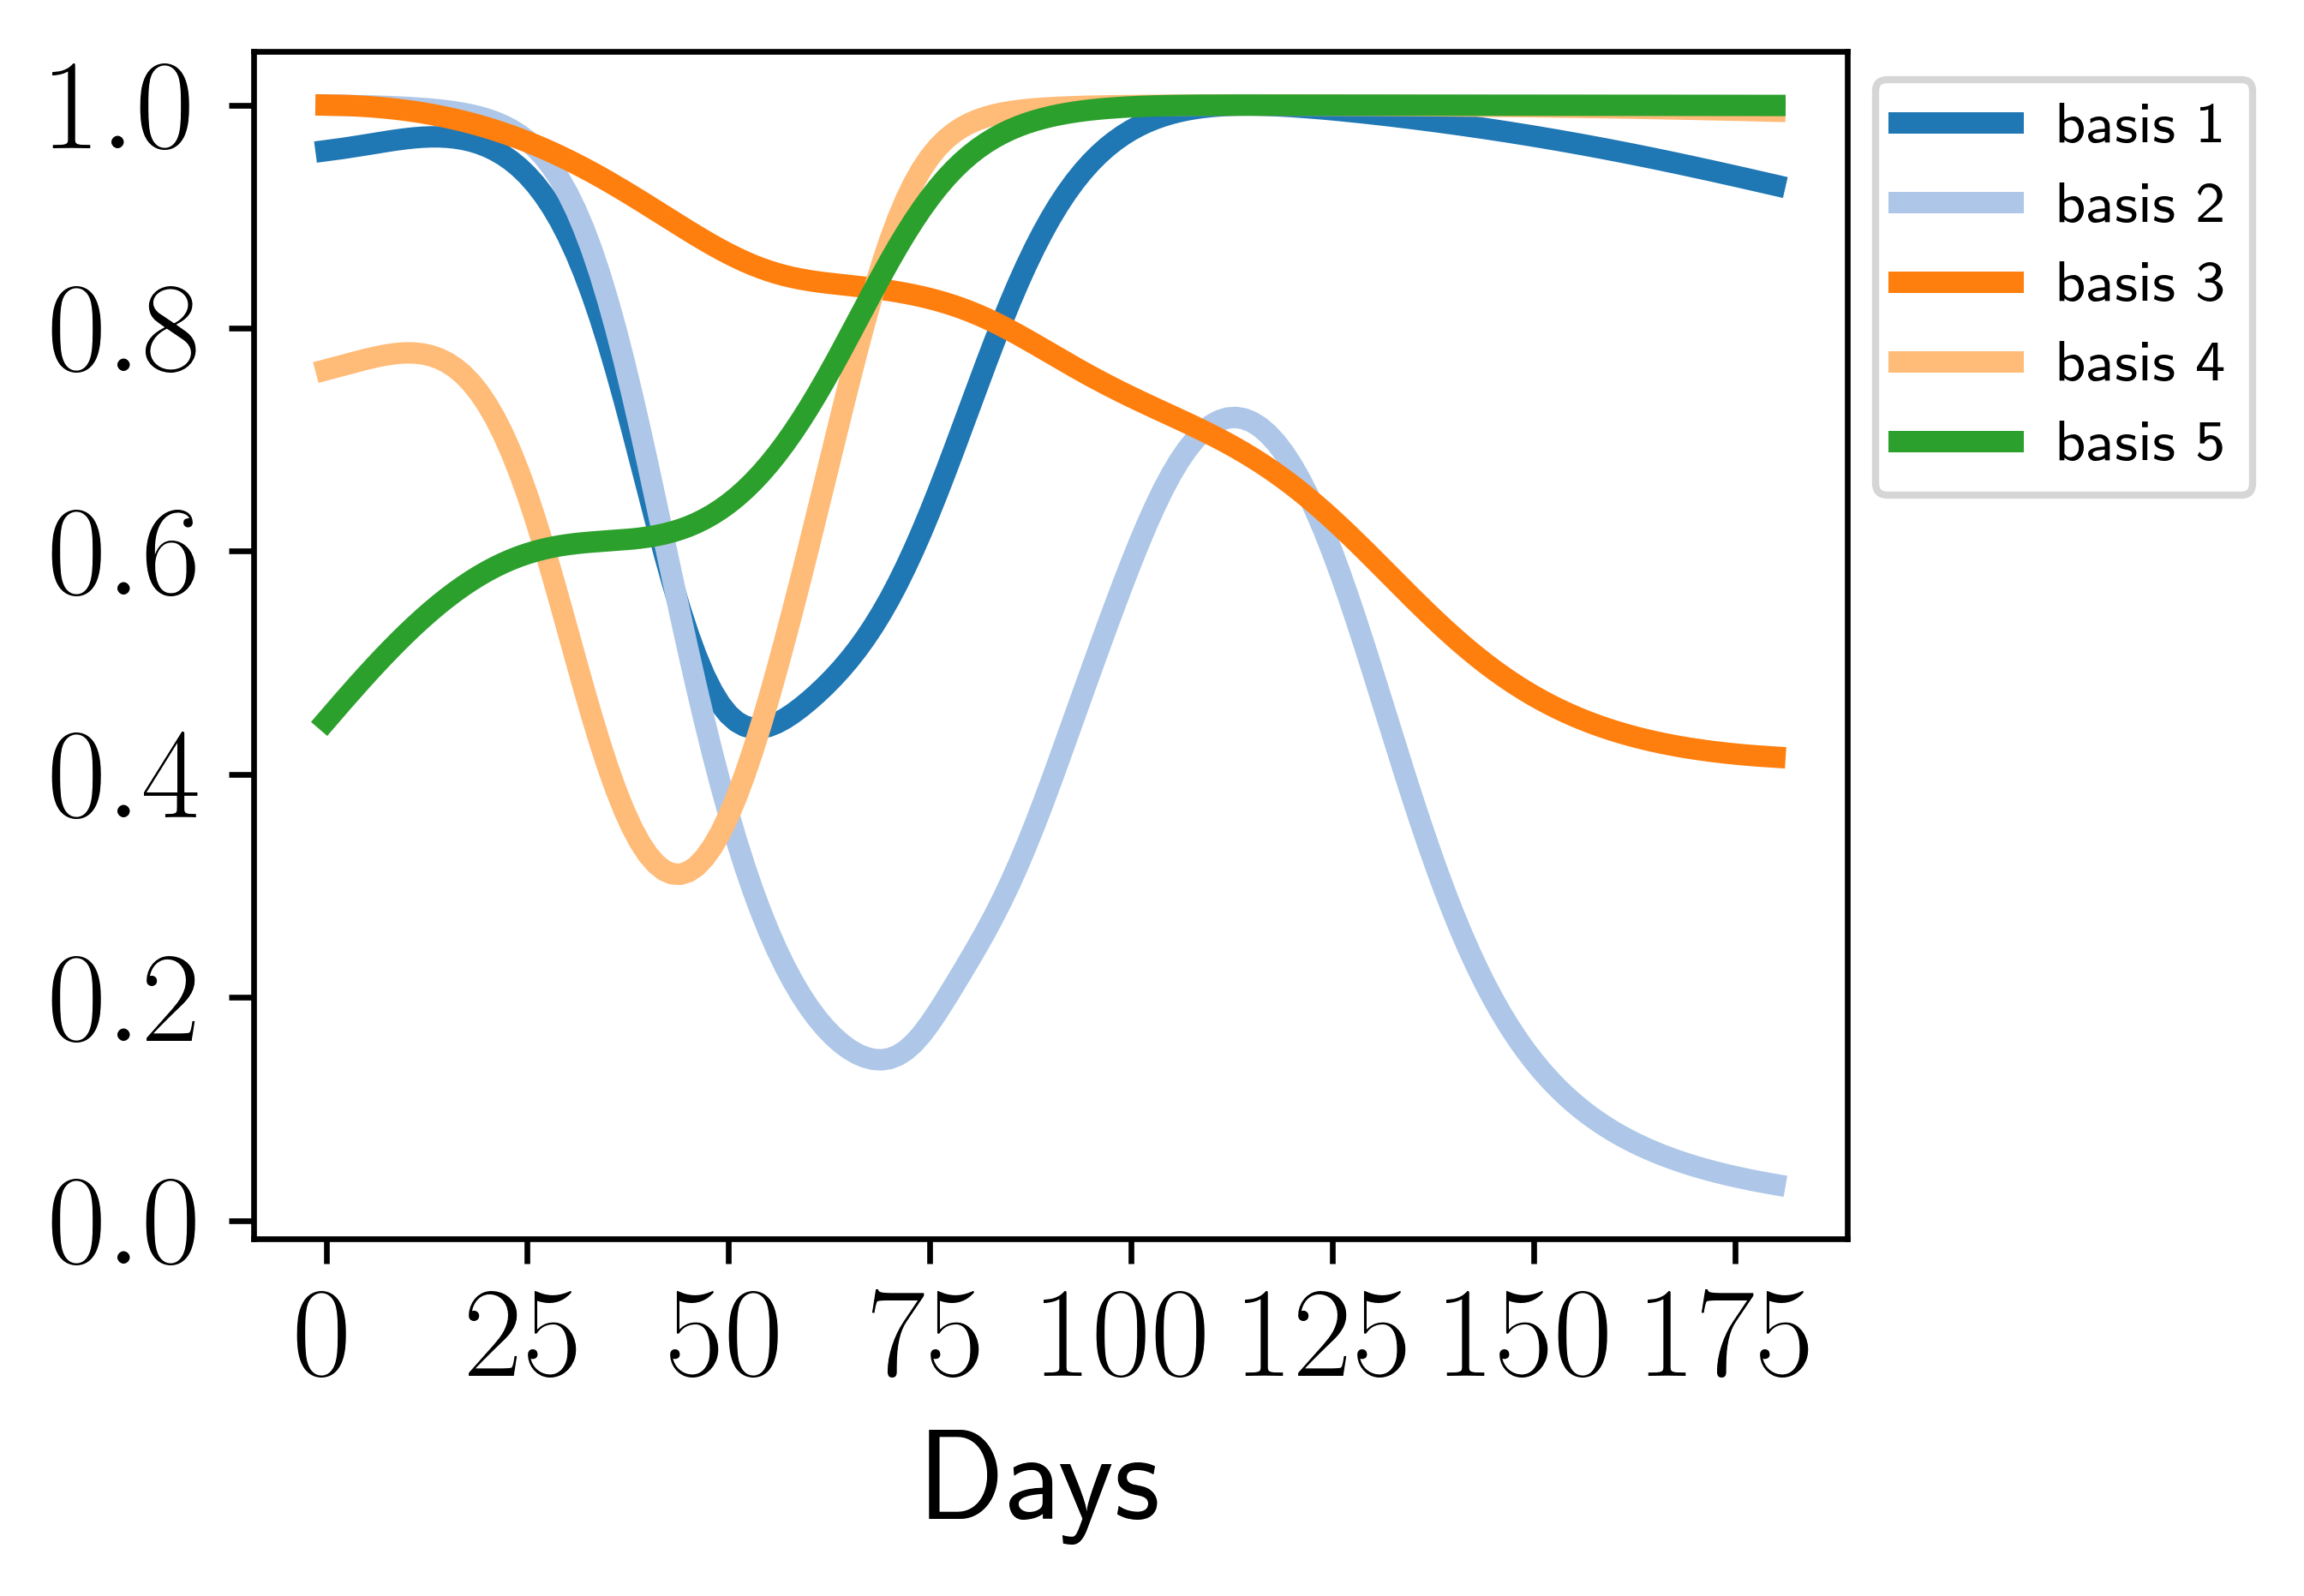

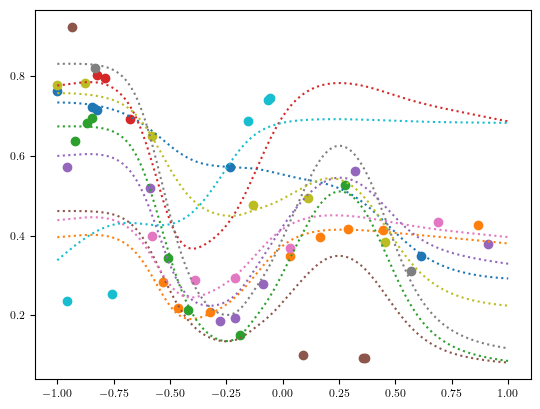

In [86]:

fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(losses_a)
ax2 = ax.twinx()
ax2.plot(rel_loss_a, color = "orange")
ax2.plot(val_loss_a, color = "green")
ax.legend(["ELBO"], loc = "upper left")
ax2.legend(["Train", "Validation"])

plt.savefig("../output_data/Basis_figures/Figure2/SignifBasisWeightViolinPlot.png", dpi = 600, bbox_inches='tight')
plt.savefig("../output_data/Basis_figures/Figure2/SignifBasisWeightViolinPlot.pdf", dpi = 600, bbox_inches='tight')

plt.show()

basis_a = get_basis(trajectory_model_a, guide_a, gene_patterns_padded_allo_train.numpy(), times_a)#gene_patterns_padded, times)
# torch.save(basis_a, "/Users/pressm/Documents/AziziLab/GVHD/Basis/GoodAlloResults/"+formatted_datetime+"basis_a.pth")
# basis_a = torch.load("/Users/pressm/Documents/AziziLab/GVHD/Basis/GoodAlloResults/_2024_04_29_10_34_01basis_a.pth")

colors = sns.color_palette("tab20", 20)

#basis = get_basis(trajectory_model, guide, gene_patterns, times)
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi = 600)
plt.rcParams.update({'font.size': 8})
ax = _plot_basis(basis_a, colors)
plt.xlabel("Days")
plt.legend(bbox_to_anchor=(1,1),loc = "upper left")

plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/SignifBasisWeightViolinPlot.png", dpi = 600, bbox_inches='tight')
plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/SignifBasisWeightViolinPlot.pdf", dpi = 600, bbox_inches='tight')

plt.show()



# gene_scales_a.T.size()
# gene_patterns[0].size()
reconstruction = samples_a['_RETURN']['mean']
original = samples_a['obs']['mean']
# test = gene_scales_a.T*reconstruction[0]

m = 10
palette = sns.color_palette(n_colors=m)
for i in range(m):
    idx = np.random.randint(0,len(gene_patterns_padded_allo_train))
    plt.scatter(times_padded, gene_patterns_padded_allo_train[idx,:].detach().numpy(), color = palette[i])
    # plt.plot(times, gene_patterns[0,idx,:].detach().numpy(), color = palette[i])
    plt.plot(times_padded, reconstruction.numpy()[idx,:], ls = ':', color = palette[i])
# plt.ylim([-0.5,10])

plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/SignifBasisWeightViolinPlot.png", dpi = 600, bbox_inches='tight')
plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/SignifBasisWeightViolinPlot.pdf", dpi = 600, bbox_inches='tight')

plt.show()



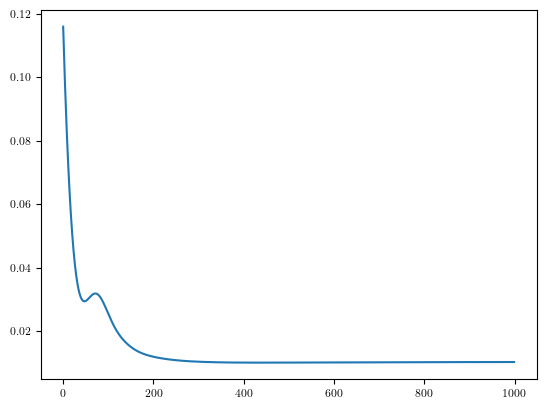

In [87]:
clear_val_params()

adam = pyro.optim.ClippedAdam({"lr": .01})#Adam({"lr": lr})
elbo = Trace_ELBO()
    
model_val = BasisDecomposition_Evaluate(
            trajectory_model_a._last_basis.detach(),#torch.Tensor(np.array(my_basis).T),
            gene_patterns_padded_allo_val.shape[0],
            beta_prior=beta_prior,
            normalized_mode = True
            
        )
guide_val = get_inference_guide(model_val, InferenceMode.POINT_ESTIMATE)
svi_val = SVI(model_val, guide_val, adam, loss=elbo)
val_loss = []
loss_val = 0
for _ in range(1000):
    loss_val = svi_val.step(torch.FloatTensor(times_padded), torch.FloatTensor(gene_patterns_padded_allo_val.numpy()))
    reconstruction_val = ((model_val._last_patterns - gene_patterns_padded_allo_val) ** 2).nanmean().item()
    val_loss.append(reconstruction_val)


plt.plot(val_loss)


samples = []
predictive = Predictive(
        model_val, guide=guide_val, num_samples=10, return_sites=("beta_val","_RETURN",  "obs_val")
    )
samples = predictive(times_a, gene_patterns_padded_allo_val)#, None)
# clone_patterns_mean = torch.FloatTensor(gene_patterns_padded_allo_val.numpy()).nanmean(axis = (1), keepdim=True) #clone_patterns_val.nanmean(axis=(1), keepdim=True)
# samples["_RETURN"] *= clone_patterns_mean
clone_scales = model_val.gene_scales #* clone_patterns_mean.squeeze(-1)
samples = summary(samples)


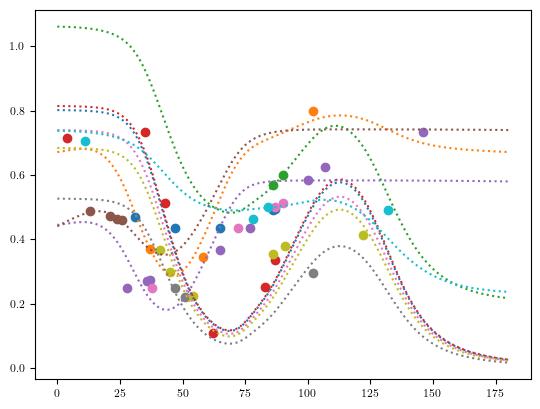

In [88]:
reconstruction_val = samples["beta_val"]["mean"].squeeze() @ basis_a.T * model_val.gene_scales.detach().numpy()

m = 10
palette = sns.color_palette(n_colors=m)
for i in range(m):
    idx = np.random.randint(0,len(gene_patterns_padded_allo_val))
    plt.scatter(np.arange(0,181), gene_patterns_padded_allo_val[idx,:].detach().numpy(), color = palette[i])
    # plt.plot(times, gene_patterns[0,idx,:].detach().numpy(), color = palette[i])
    plt.plot(np.arange(0,181), reconstruction_val.numpy()[idx,:], ls = ':', color = palette[i])
plt.show()

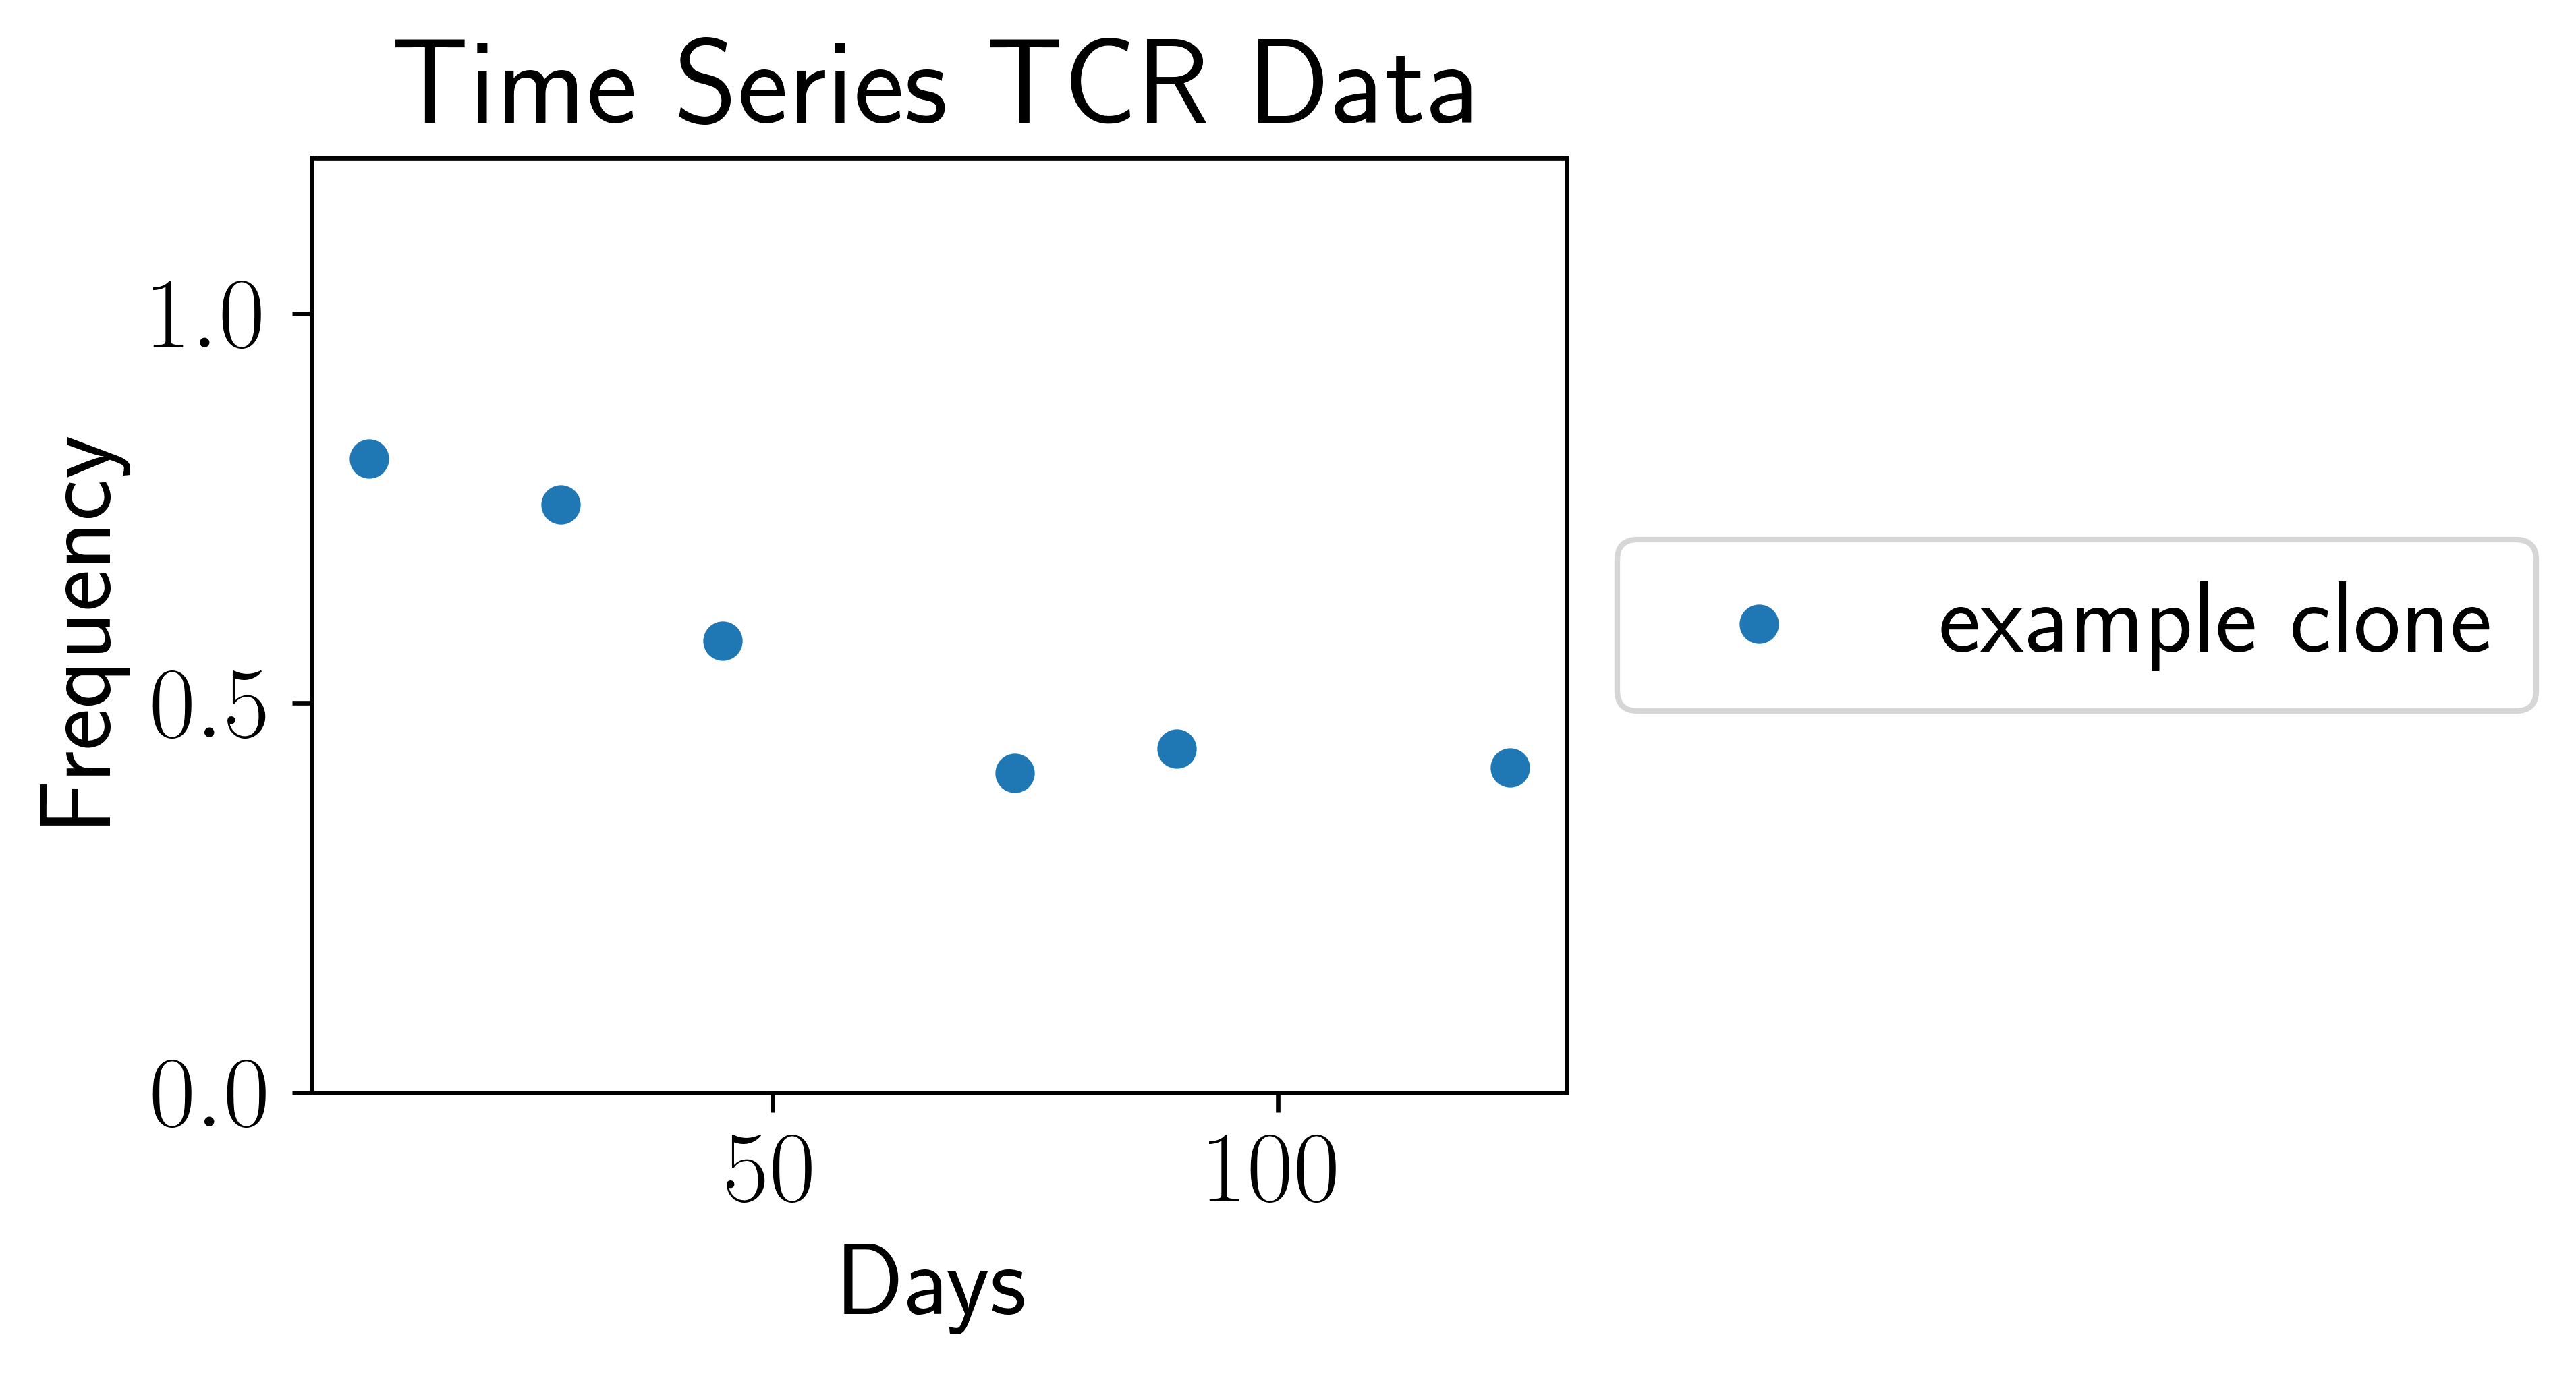

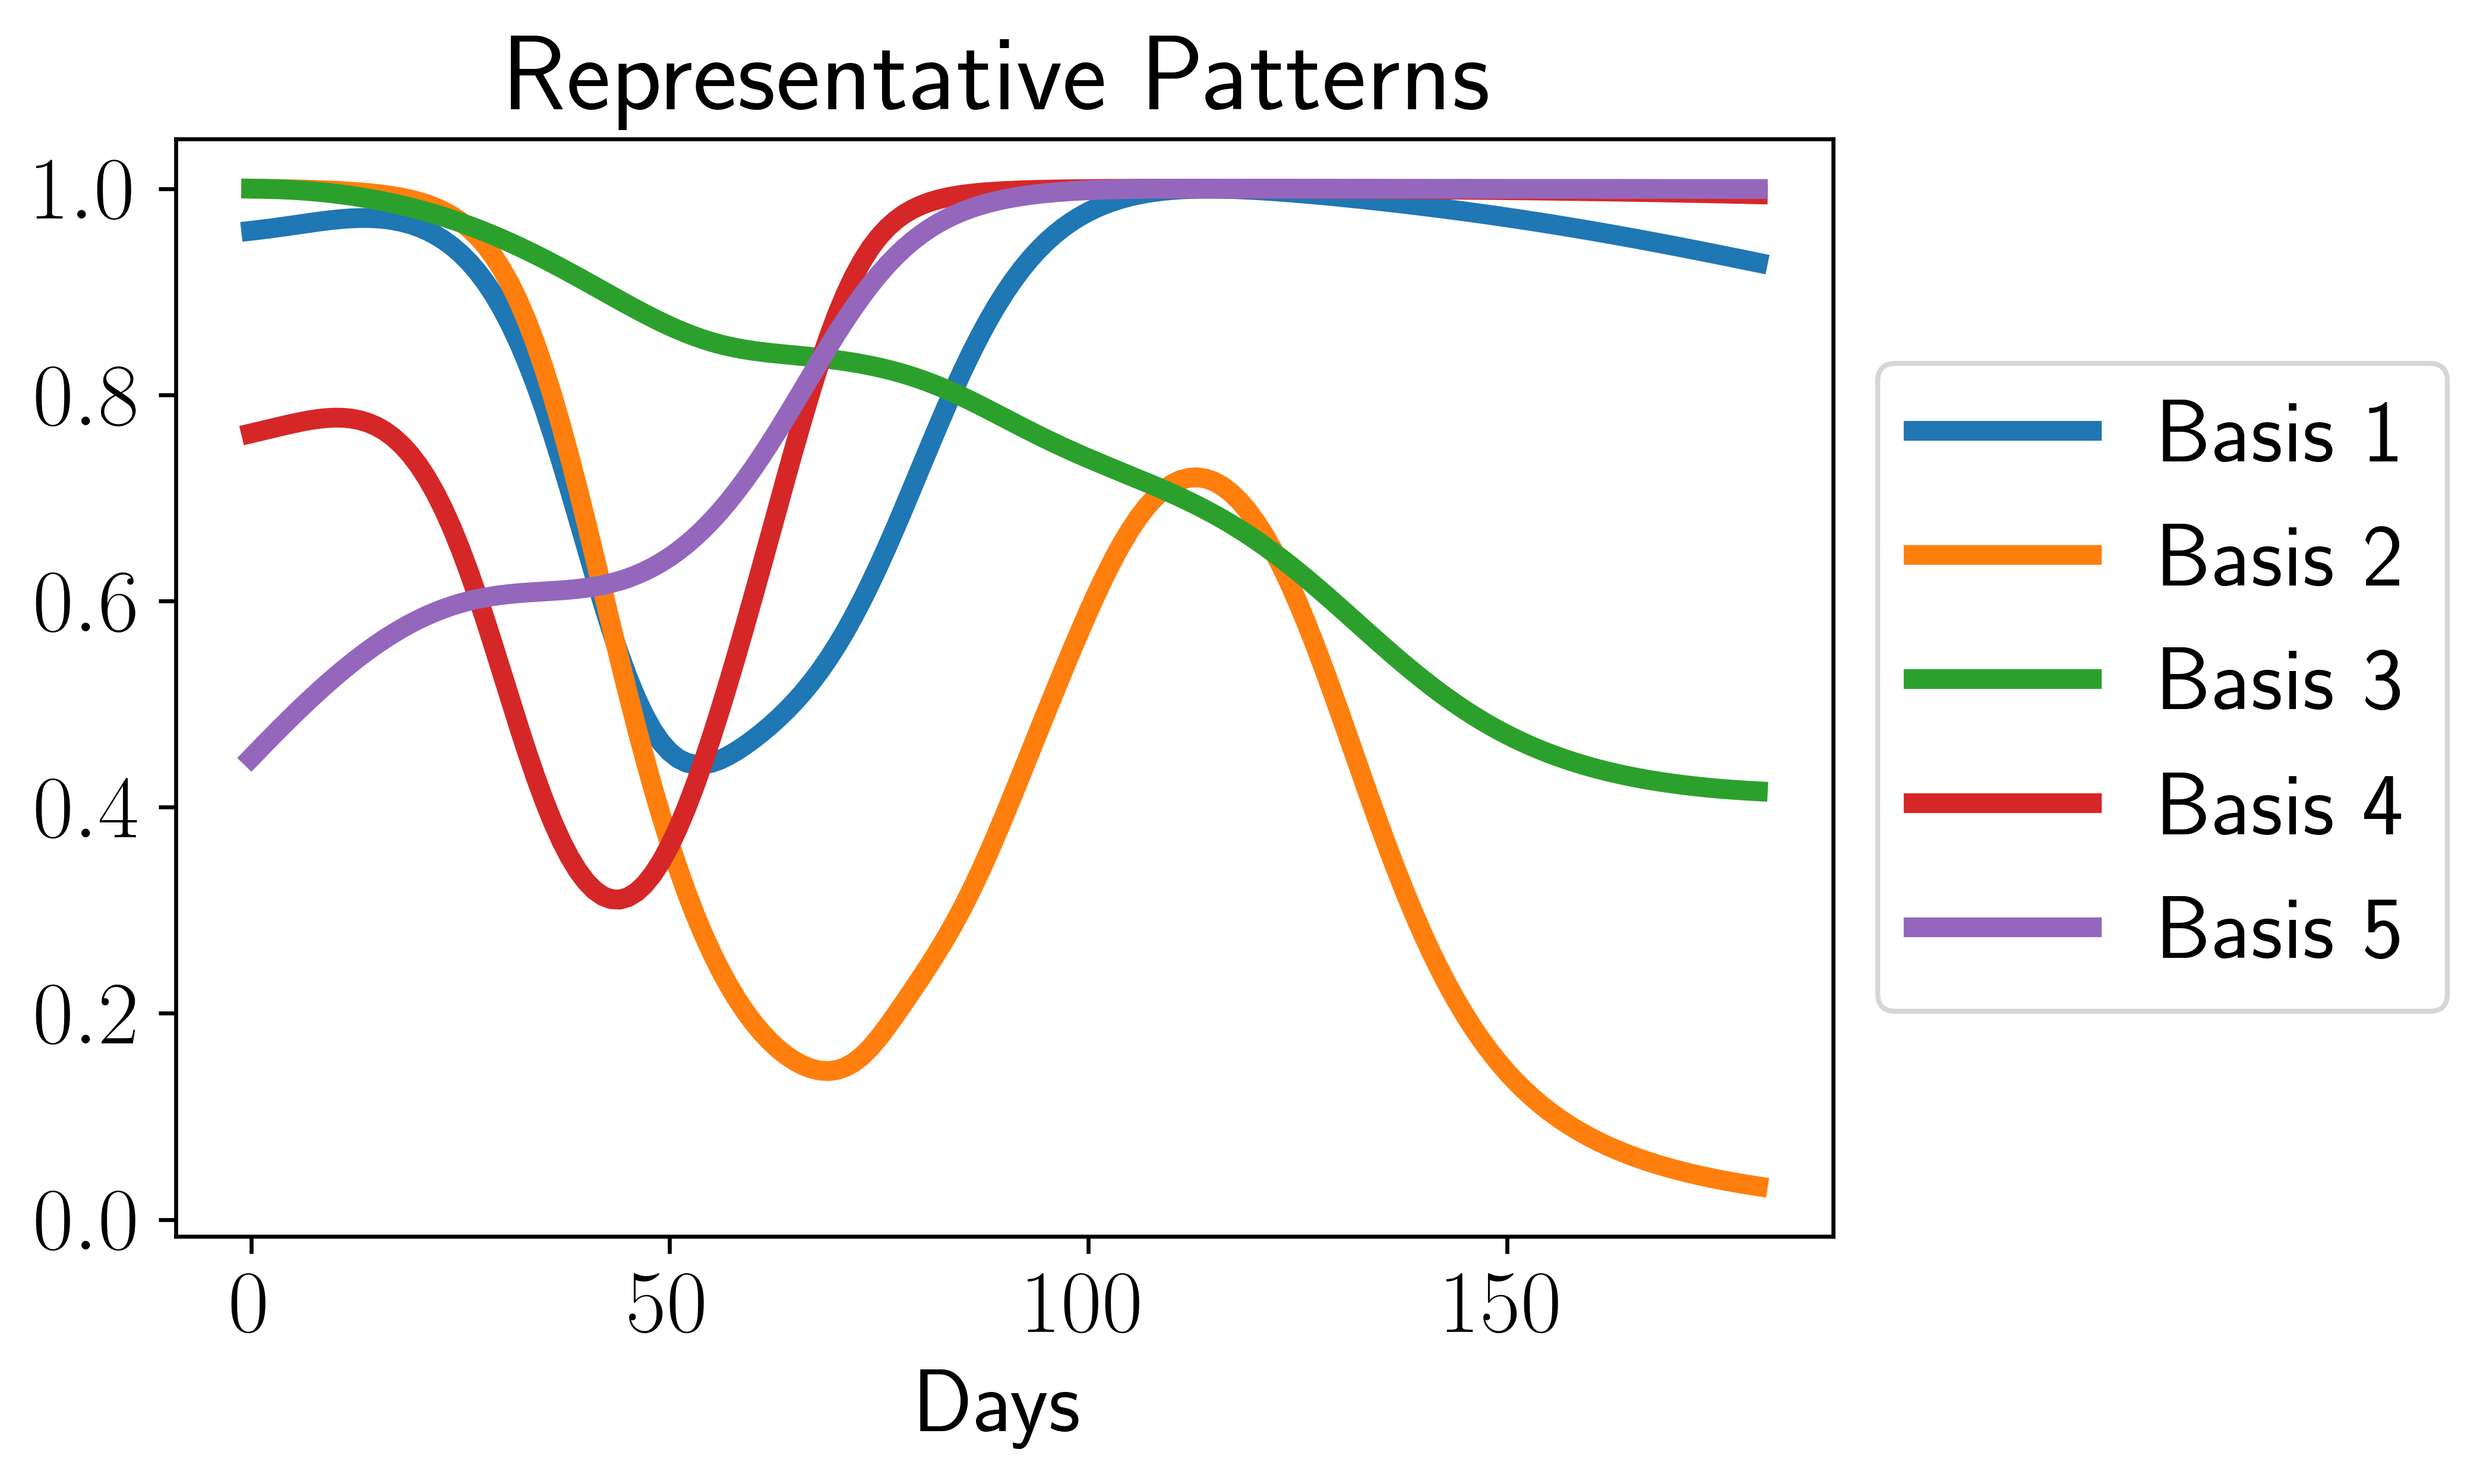

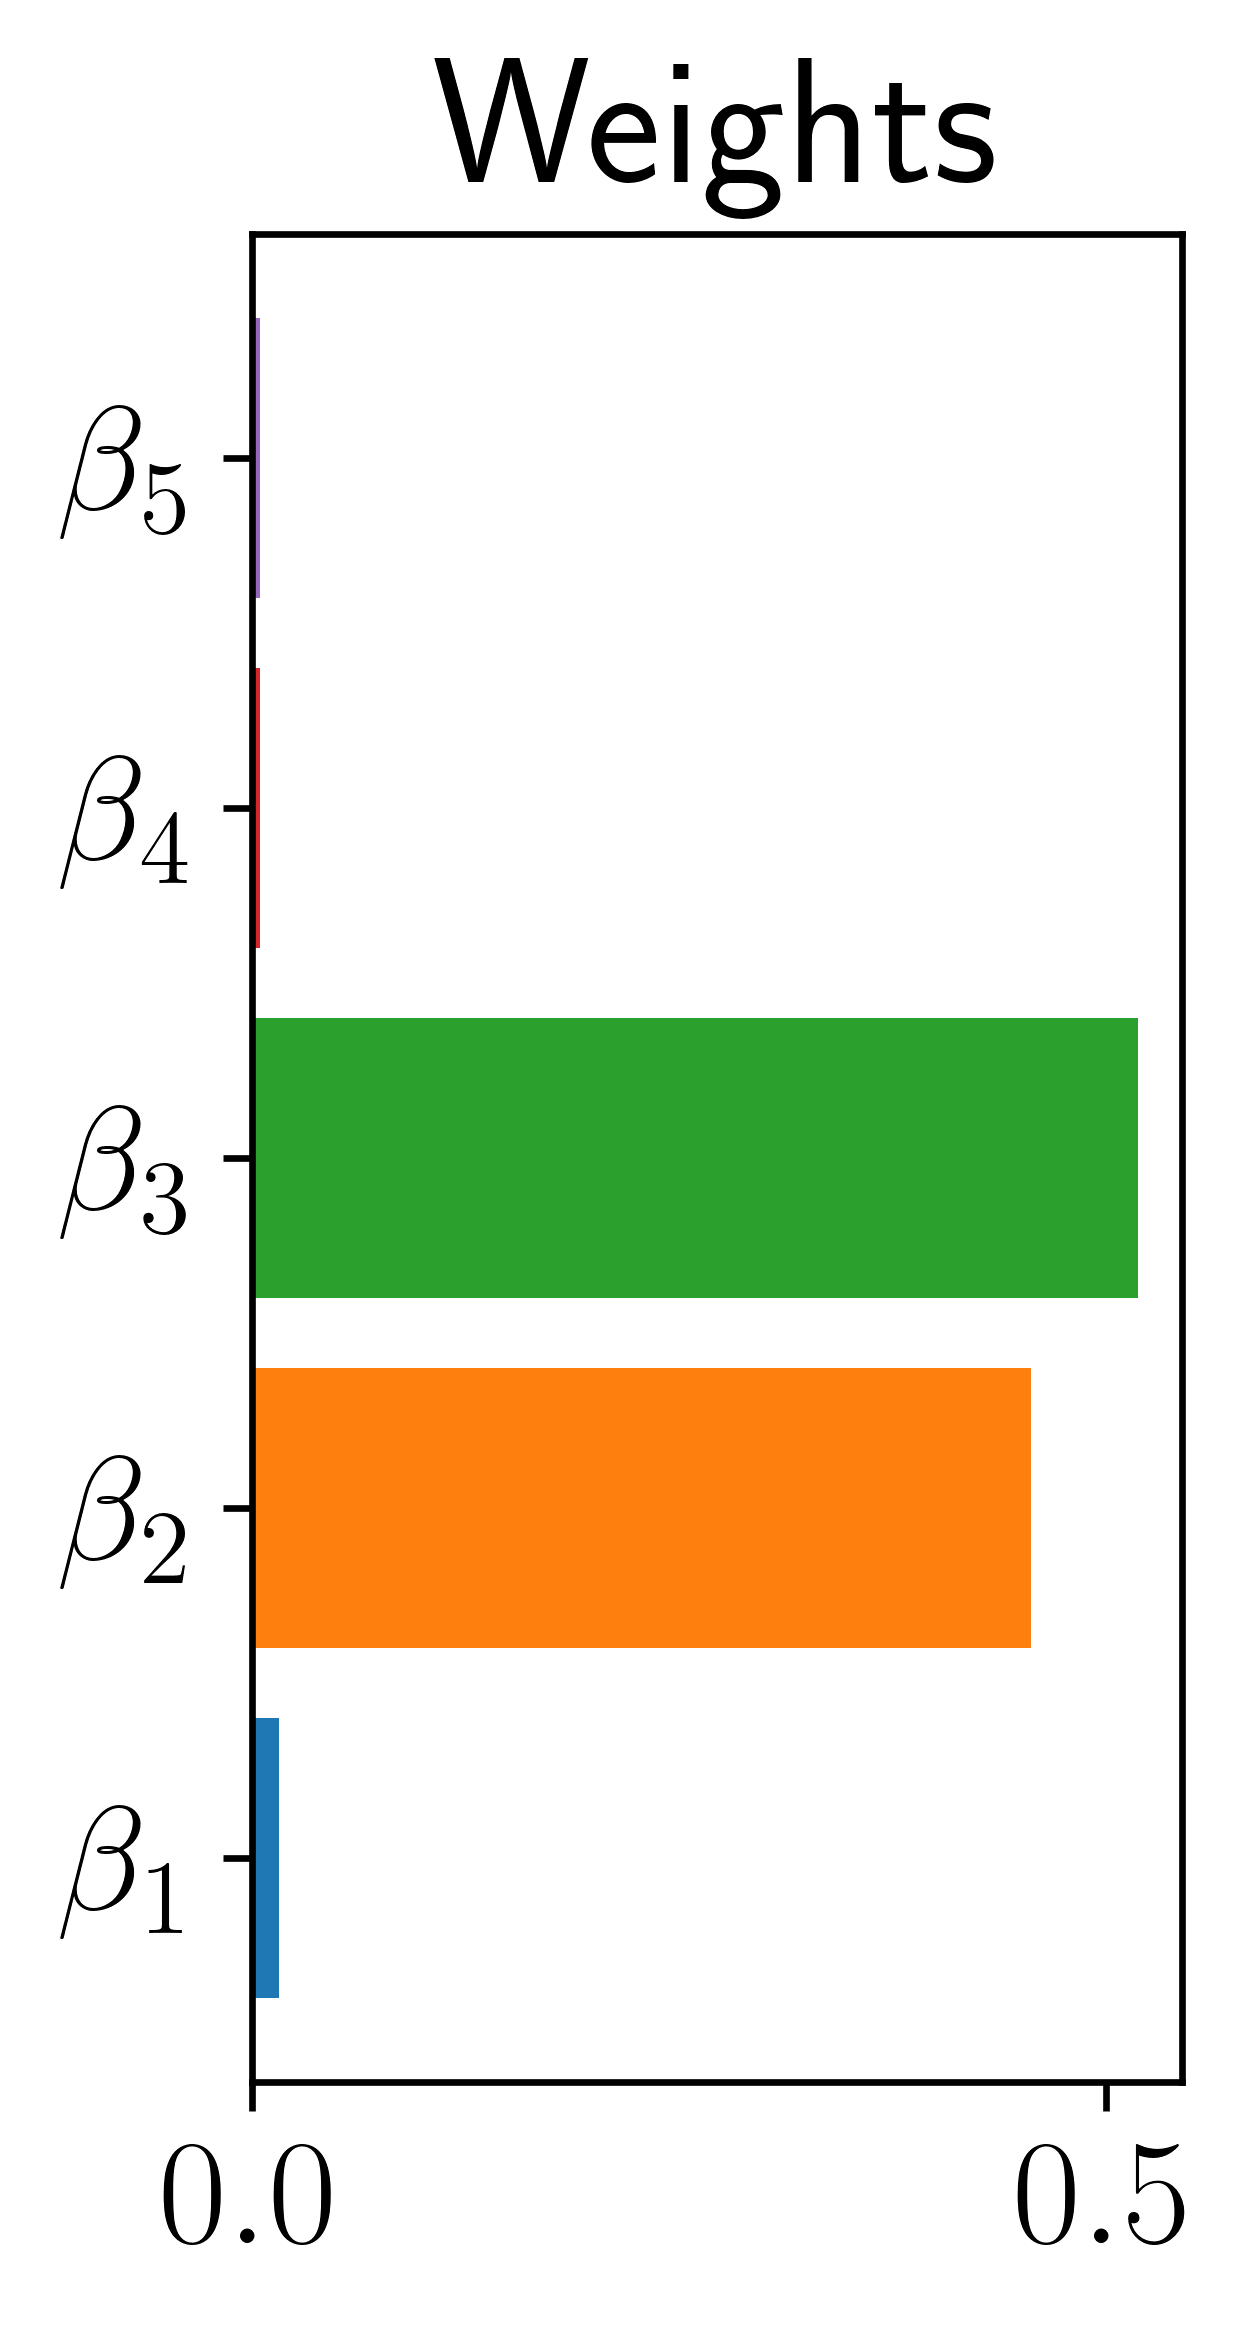

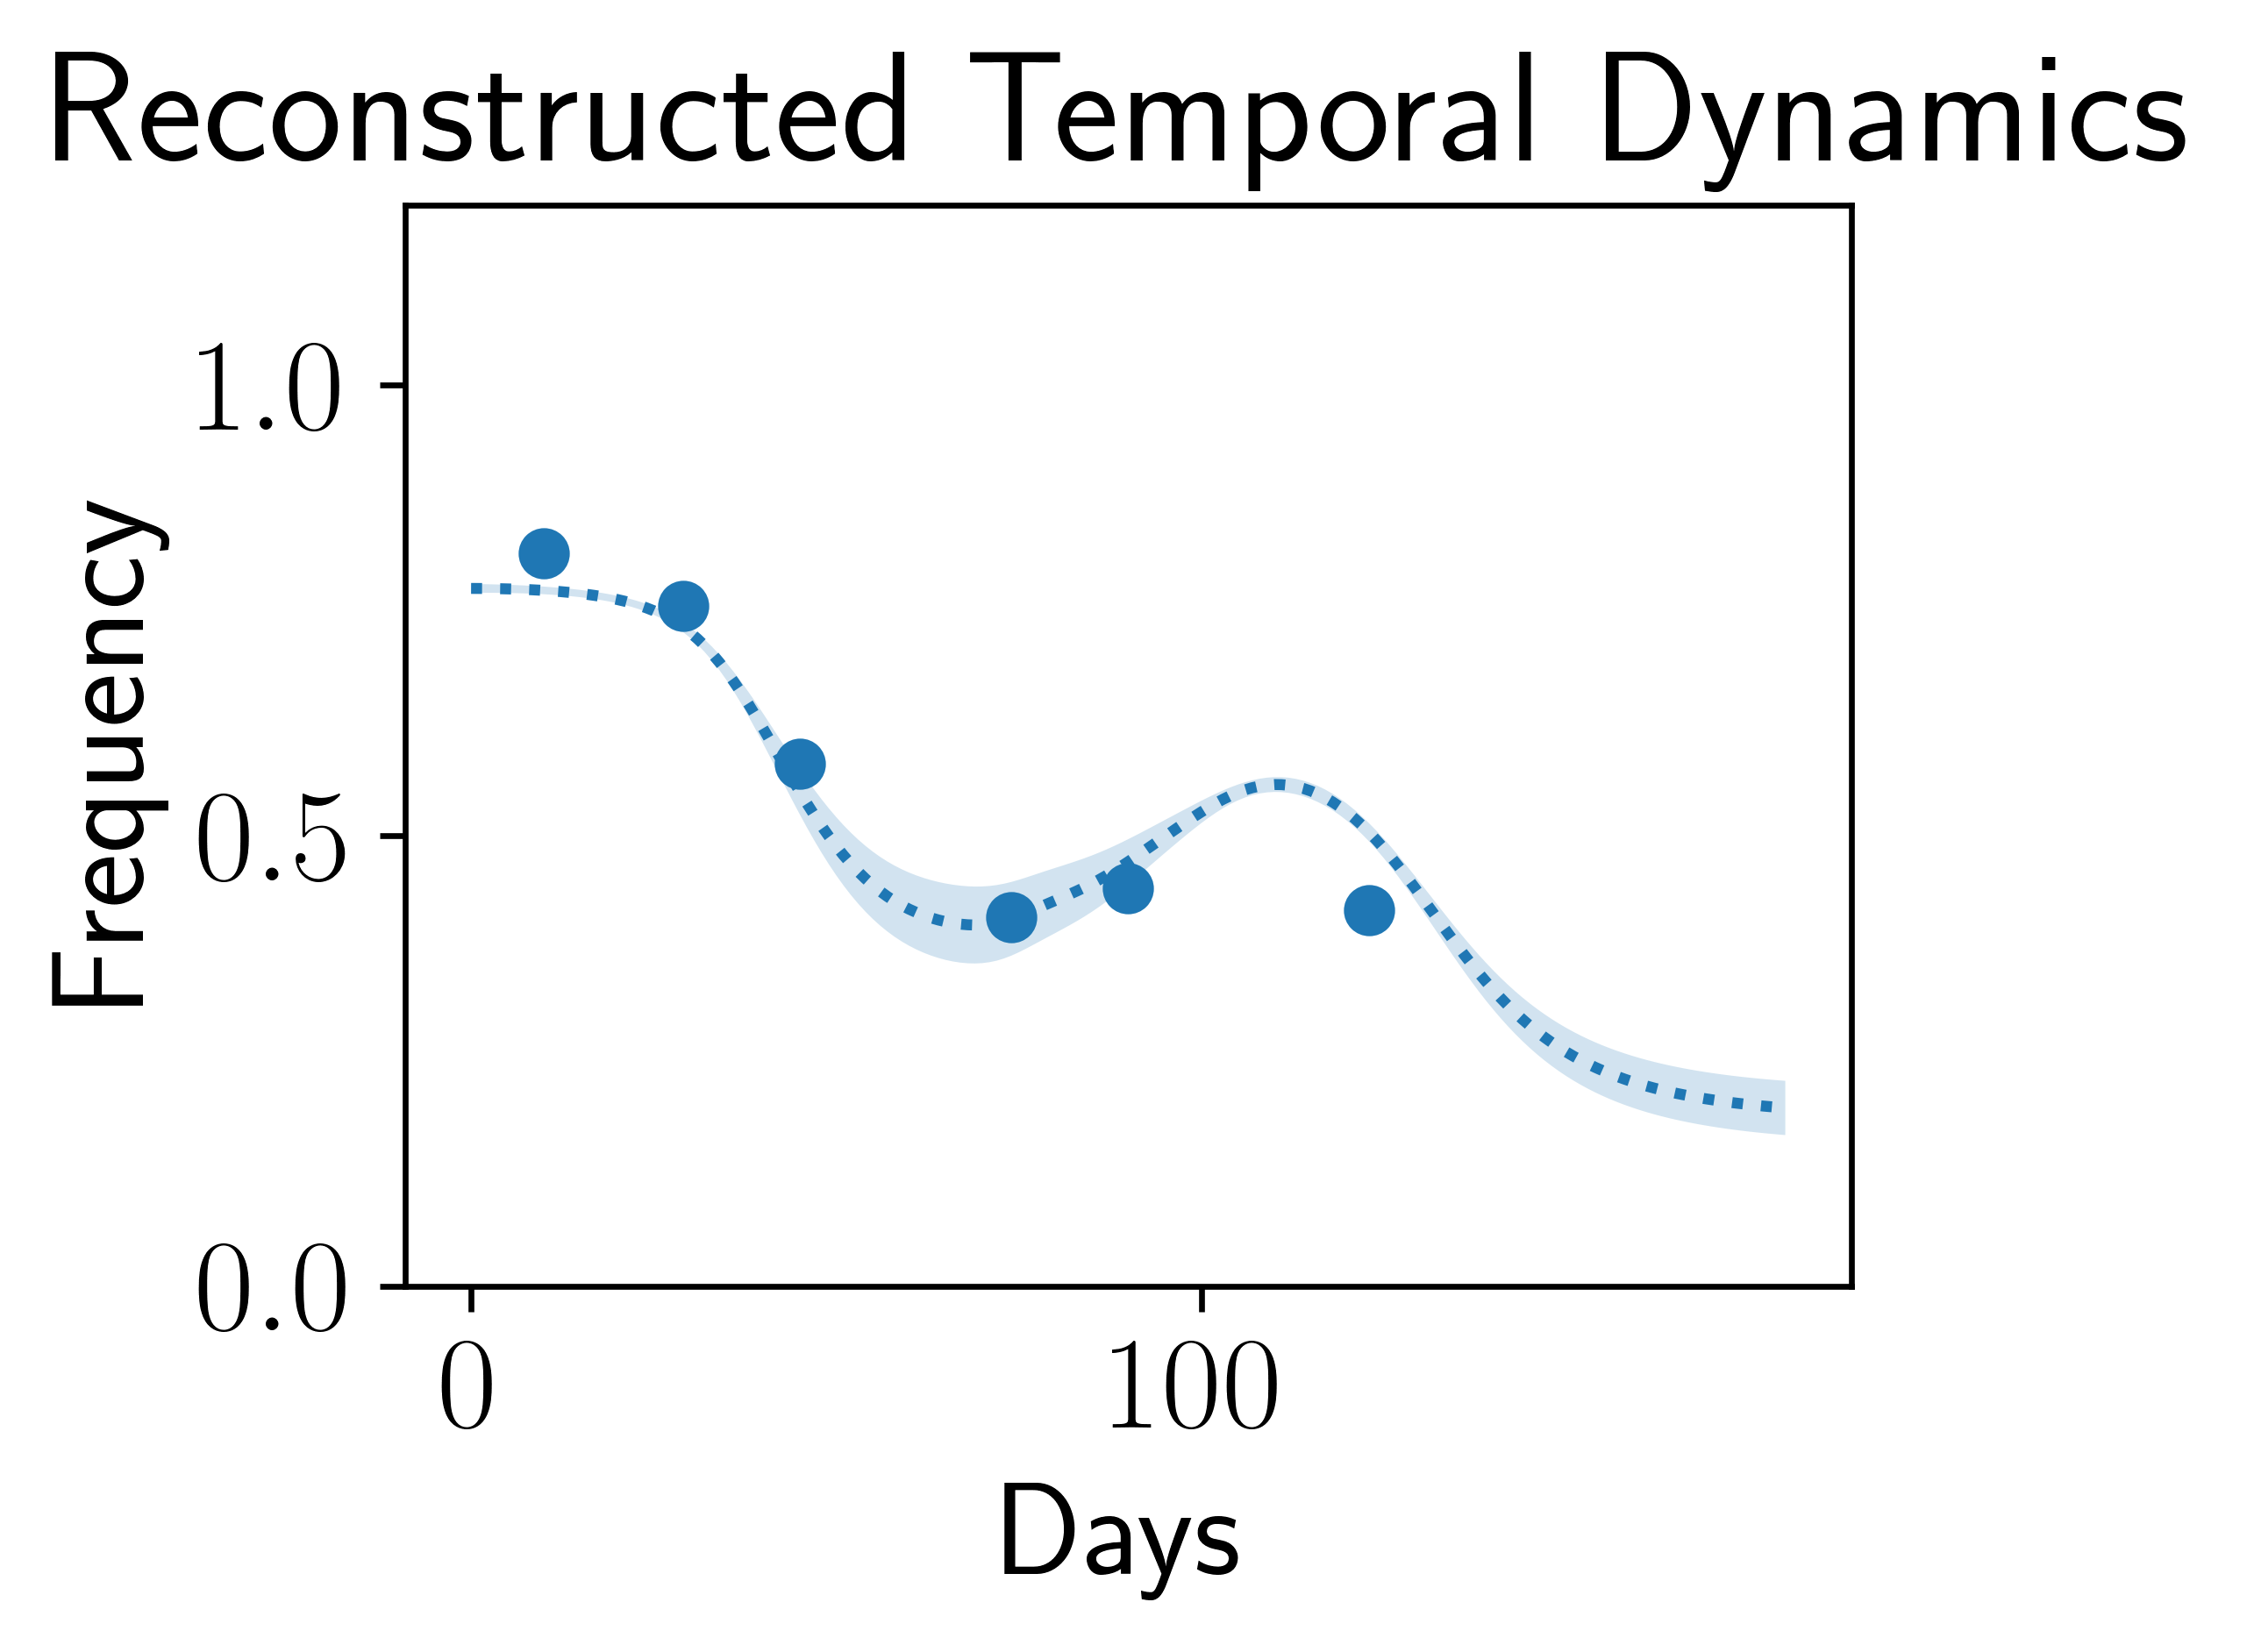

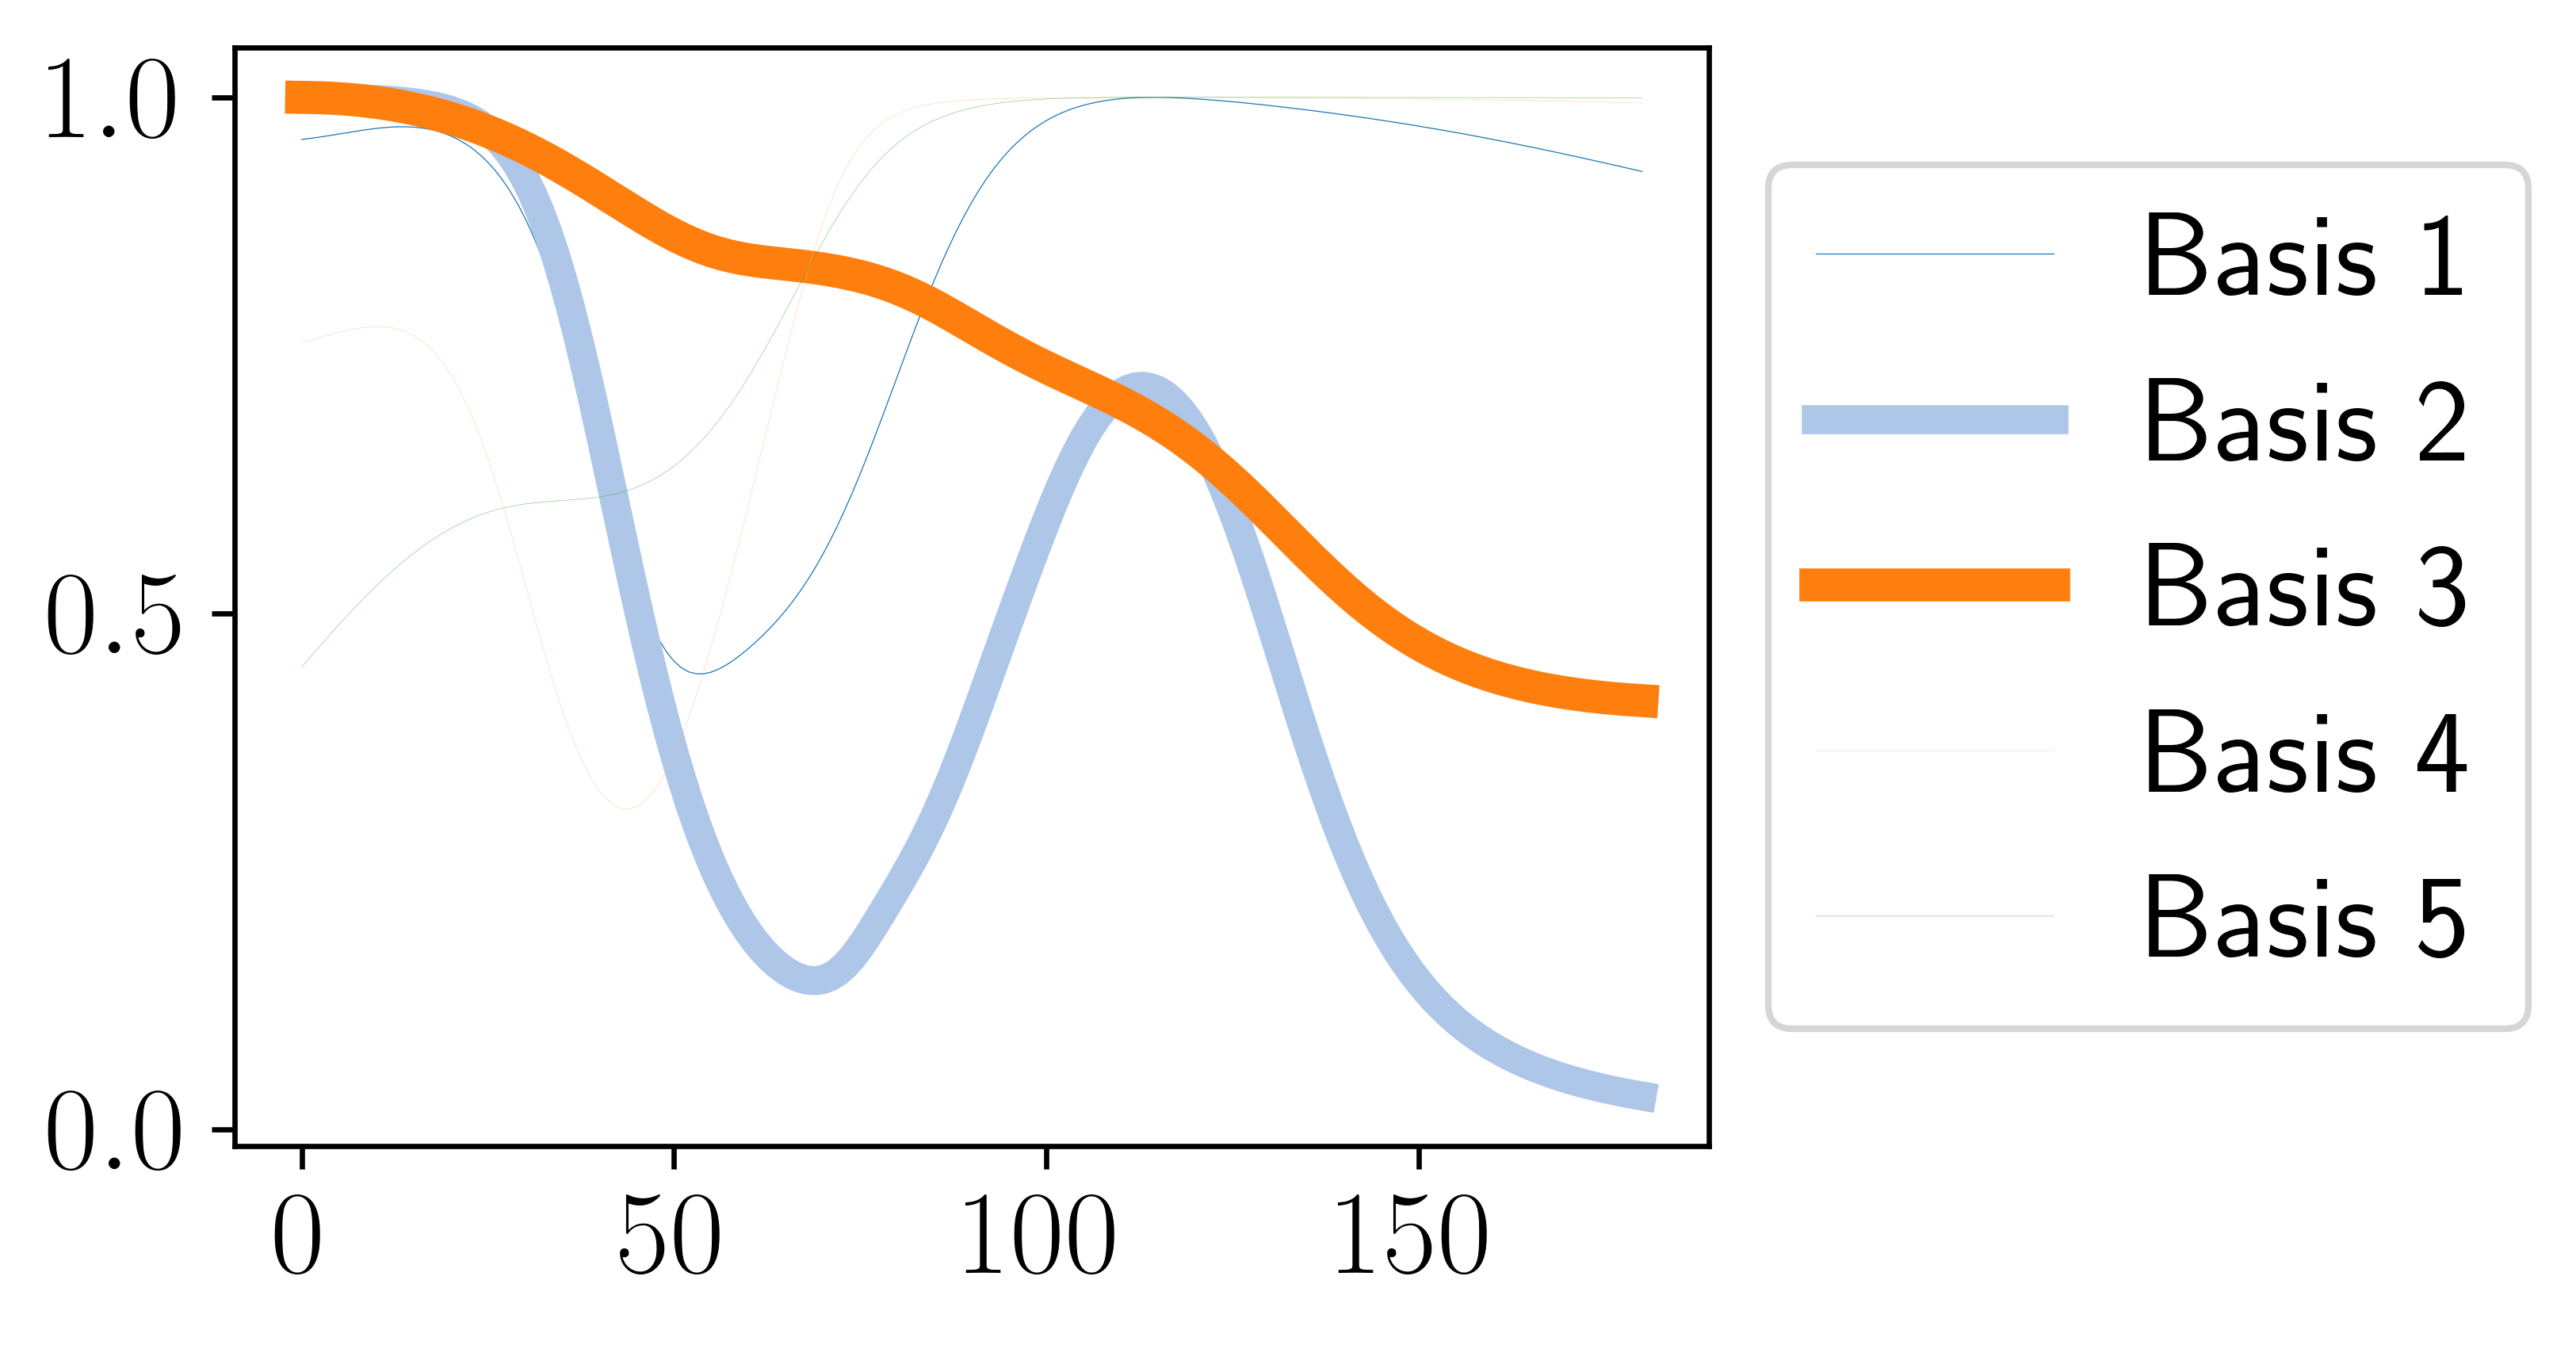

In [89]:
# gene_scales_a.T.size()
# gene_patterns[0].size()
reconstruction = samples_a['_RETURN']['mean']
reconstruction_std = samples_a["_RETURN"]["std"]
reconstruction_q05 = samples_a['_RETURN']['quantile05']
reconstruction_q95 = samples_a['_RETURN']['quantile95']
original = samples_a['obs']['mean']
# test = gene_scales_a.T*reconstruction[0]


plt.rcParams.update({'font.size': 18, "text.usetex":True })

m = 1
palette = sns.color_palette(n_colors = 1)[0]
idx = 0
fig, ax = plt.subplots(1,1, figsize = (4,3), dpi = 600)
idx = np.random.randint(0,len(gene_patterns_padded_allo_train))
ax.scatter(np.arange(0,181), gene_patterns_padded_allo_train[idx,:].detach().numpy(), color = palette)
ax.set_xlabel("Days")
ax.set_ylabel("Frequency")
ax.set_ylim([0,1.2])
ax.set_title("Time Series TCR Data")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ["example clone"])
# plt.ylim([-0.5,10])
plt.savefig("../output_data/Basis_figures/Figure2/example_sim_sample.png", dpi = 600, bbox_inches='tight')
plt.savefig("../output_data/Basis_figures/Figure2/example_sim_sample.pdf", dpi = 600, bbox_inches='tight')
plt.show()

sample_beta = samples_a["beta"]["mean"].squeeze()[idx,:]

fig, ax = plt.subplots(1,1, figsize = (6,4), dpi = 600)
for i in range(basis_a.shape[-1]):
    ax.plot(basis_a[:,i], linewidth = 4, color = sns.color_palette("tab10",n_colors=n_basis)[i])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ["Basis {}".format(x) for x in range(1,n_basis+1)])
    
ax.set_title("Representative Patterns")
ax.set_xlabel("Days")

plt.savefig("../output_data/Basis_figures/Figure2/example_basis.png", dpi = 600, bbox_inches='tight')
plt.savefig("../output_data/Basis_figures/Figure2/example_basis.pdf", dpi = 600, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,1, figsize = (2,4), dpi = 600)
ax.barh(y = np.arange(1,n_basis + 1), width = sample_beta, color = sns.color_palette("tab10",n_colors=n_basis))
ax.set_yticks(np.arange(1,n_basis+1))
ax.set_yticklabels(["$\\beta_{"+str(x)+"}$" for x in range(1,n_basis+1)])
ax.set_title("Weights")


plt.savefig("../output_data/Basis_figures/Figure2/example_weights.png", dpi = 600, bbox_inches='tight')
plt.savefig("../output_data/Basis_figures/Figure2/example_weights.pdf", dpi = 600, bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(1,1, figsize = (4,3), dpi = 600)
fig.tight_layout()
ax.scatter(np.arange(0,181), gene_patterns_padded_allo_train[idx,:].detach().numpy(), color = palette)
ax.plot(np.arange(0,181), reconstruction.numpy()[idx,:], ls = ':', color = palette)
ax.fill_between(np.arange(0,181), y1 = reconstruction.numpy()[idx,:] - reconstruction_std.numpy()[idx,:], y2 = reconstruction.numpy()[idx,:] + reconstruction_std.numpy()[idx,:], alpha = 0.2)
ax.set_xlabel("Days")
ax.set_ylabel("Frequency")
ax.set_title("Reconstructed Temporal Dynamics")
ax.set_ylim([0,1.2])
plt.savefig("../output_data/Basis_figures/Figure2/example_reconstructed.png", dpi = 600, bbox_inches='tight')
plt.savefig("../output_data/Basis_figures/Figure2/example_reconstructed.pdf", dpi = 600, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1,1, figsize = (4,3), dpi = 600)
line_width = samples_a['beta']['mean'].squeeze()[idx,:]
line_width = line_width/line_width.max() * 5

for i in range(basis_a.shape[-1]):
    ax.plot(basis_a[:,i], linewidth = line_width[i], color = sns.color_palette("tab20",n_colors=n_basis)[i])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ["Basis {}".format(x) for x in range(1,n_basis+1)])

plt.show()

0.8481178824824516
(2, 41996)


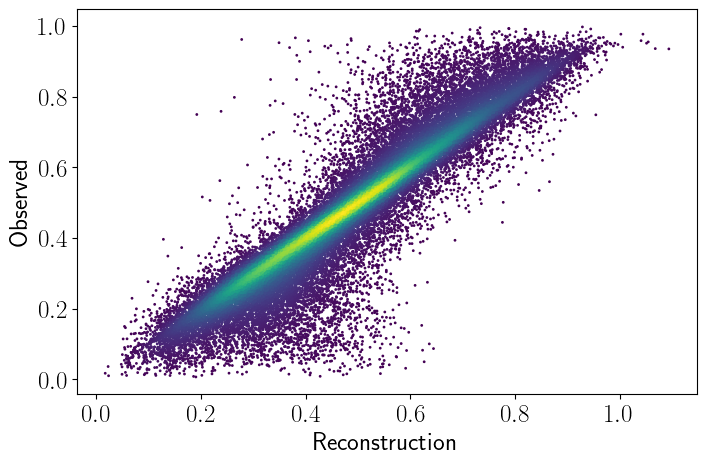

0.7891625278121008


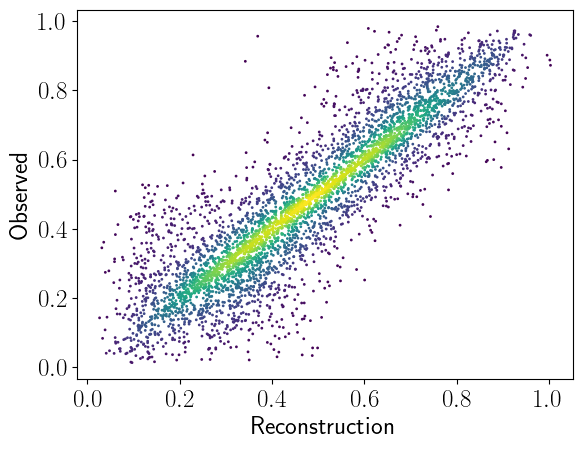

In [90]:
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
# gene_scales_a.T.size()
# gene_patterns[0].size()
reconstruction_val = samples["beta_val"]["mean"].squeeze() @ basis_a.T * model_val.gene_scales.detach().numpy()
reconstruction = samples_a['_RETURN']['mean']
original = samples_a['obs']['mean']
# test = gene_scales_a.T*reconstruction[0]

train_R2 = r2_score(gene_patterns_padded_allo_train.detach().numpy()[~torch.isnan(gene_patterns_padded_allo_train.detach())].flatten(),reconstruction.numpy()[~torch.isnan(gene_patterns_padded_allo_train.detach())].flatten())
print(train_R2)

d = np.vstack([reconstruction.numpy()[~torch.isnan(gene_patterns_padded_allo_train.detach())], gene_patterns_padded_allo_train.detach().numpy()[~torch.isnan(gene_patterns_padded_allo_train.detach())]])
kernel = gaussian_kde(d)
values = kernel(d)
print(d.shape)
fig, ax = plt.subplots(1,1, figsize = (8,5))

m = 5
ax.scatter(reconstruction.numpy()[~torch.isnan(gene_patterns_padded_allo_train.detach())], gene_patterns_padded_allo_train.detach().numpy()[~torch.isnan(gene_patterns_padded_allo_train.detach())], s = 1,
            c = values)

ax.set_ylabel("Observed")
ax.set_xlabel("Reconstruction")

plt.savefig("../output_data/Basis_figures/Figure2/R2onTrain.png", dpi = 600, bbox_inches='tight')
plt.savefig("../output_data/Basis_figures/Figure2/R2onTrain.pdf", dpi = 600, bbox_inches='tight')

plt.show()


val_R2 = r2_score(gene_patterns_padded_allo_val.detach().numpy()[~torch.isnan(gene_patterns_padded_allo_val.detach())].flatten(),reconstruction_val.numpy()[~torch.isnan(gene_patterns_padded_allo_val.detach())].flatten())
print(val_R2)

d = np.vstack([reconstruction_val.numpy()[~torch.isnan(gene_patterns_padded_allo_val.detach())], gene_patterns_padded_allo_val.detach().numpy()[~torch.isnan(gene_patterns_padded_allo_val.detach())]])
kernel = gaussian_kde(d)
values = kernel(d)

m = 5
plt.scatter(reconstruction_val.numpy()[~torch.isnan(gene_patterns_padded_allo_val.detach())], gene_patterns_padded_allo_val.detach().numpy()[~torch.isnan(gene_patterns_padded_allo_val.detach())], s = 1,
            c = values)

plt.ylabel("Observed")
plt.xlabel("Reconstruction")

plt.savefig("../output_data/Basis_figures/Figure2/R2onVal.png", dpi = 600, bbox_inches='tight')
plt.savefig("../output_data/Basis_figures/Figure2/R2onVal.pdf", dpi = 600, bbox_inches='tight')

plt.show()

0.37967889375892616


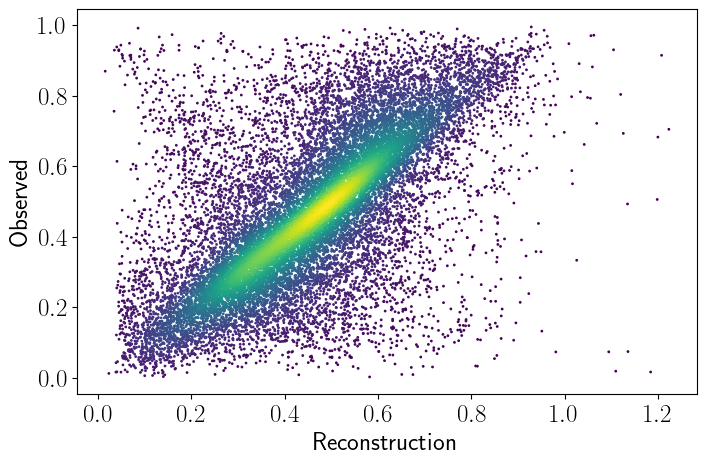

In [91]:
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
# gene_scales_a.T.size()
# gene_patterns[0].size()
reconstruction_val = samples["beta_val"]["mean"].squeeze() @ basis_a.T * model_val.gene_scales.detach().numpy()
reconstruction = samples_a['_RETURN']['mean']
original = samples_a['obs']['mean']
# test = gene_scales_a.T*reconstruction[0]

train_R2 = r2_score(gt_train.numpy().flatten(),reconstruction.numpy().flatten())
print(train_R2)

rand_idx = np.random.randint(0, len(reconstruction.numpy().flatten()), 20000)

d = np.vstack([reconstruction.numpy().flatten()[rand_idx], gt_train.numpy().flatten()[rand_idx]])
kernel = gaussian_kde(d)
values = kernel(d)

fig, ax = plt.subplots(1,1, figsize = (8,5))

# m = 5
ax.scatter(reconstruction.numpy().flatten()[rand_idx], gt_train.numpy().flatten()[rand_idx], s = 1,c = values)

ax.set_ylabel("Observed")
ax.set_xlabel("Reconstruction")

plt.savefig("../output_data/Basis_figures/Figure2/R2OnAll.png", dpi = 600, bbox_inches='tight')
plt.savefig("../output_data/Basis_figures/Figure2/R2OnAll.pdf", dpi = 600, bbox_inches='tight')

plt.show()

In [92]:
gene_patterns_padded_allo_train.nanmean(axis = (1)).shape

torch.Size([9000])

In [93]:
gene_scales_a = gene_scales_a.detach().numpy()
gene_scales_a = np.expand_dims(gene_scales_a, axis = 0)

beta_a = samples_a['beta']['mean'].squeeze()
beta_a = beta_a[:len(train_a_idx)]
beta_and_scale_a = np.concatenate([beta_a], axis = 1) #gene_scales_a.T
beta_and_scale_df_a = pd.DataFrame(beta_and_scale_a)
col_names = np.concatenate([np.linspace(1, n_basis, n_basis, dtype = int).astype(str), ["gene_scales"]])

beta_a_val = samples['beta_val']['mean'].squeeze()
beta_a_val = beta_a_val[:len(val_a_idx)]
beta_and_scale_a_val = np.concatenate([beta_a_val], axis = 1) #gene_scales_a.T
beta_and_scale_df_a_val = pd.DataFrame(beta_and_scale_a_val)
col_names = np.concatenate([np.linspace(1, n_basis, n_basis, dtype = int).astype(str), ["gene_scales"]])

adjacency = kneighbors_graph(np.concatenate([beta_and_scale_df_a.values,beta_and_scale_df_a_val.values]), 
                             n_neighbors = 300, 
                             mode = "distance" , 
                             metric = "euclidean")


louvain = Louvain(.15)
labels_allo = louvain.fit_predict(adjacency)
labels_allo_train = labels_allo[:beta_and_scale_a.shape[0]]
labels_allo_val = labels_allo[beta_and_scale_a.shape[0]:]
print(np.unique(labels_allo))

new_categorical = pd.DataFrame(random_weights)
new_categorical.columns = new_categorical.columns + 1


new_categorical["Grade"] = labels_allo

n_No = np.round(12*np.sum(labels_allo == 0)/len(labels_allo))
n_Mild = np.round(12*np.sum(labels_allo == 1)/len(labels_allo))
n_Severe = np.round(12*np.sum(labels_allo == 2)/len(labels_allo))
print(n_No)
print(n_Mild)
print(n_Severe)

start = 1

for idx, n in enumerate(np.cumsum([n_No, n_Mild, n_Severe])):
    new_categorical.loc[labels_allo == idx, "PatientID"] = np.random.randint(start, start+n, np.sum(labels_allo == idx))
    start += n


new_categorical

[0 1]
7.0
5.0
0.0


1         2         3         4         5  Grade  PatientID
0     0.151401  0.041811  0.797688  0.007792  0.001309      0        3.0
1     0.000857  0.440123  0.493948  0.000552  0.064520      1        8.0
2     0.017115  0.063652  0.019984  0.032048  0.867202      0        2.0
3     0.675655  0.181264  0.050763  0.064171  0.028147      1        8.0
4     0.228577  0.385886  0.084317  0.046041  0.255178      1       17.0
...        ...       ...       ...       ...       ...    ...        ...
9995  0.064328  0.287025  0.082468  0.286790  0.279389      1       12.0
9996  0.028050  0.006884  0.397239  0.245720  0.322107      1        9.0
9997  0.557666  0.004281  0.226718  0.131022  0.080312      0        7.0
9998  0.023124  0.657834  0.045830  0.003756  0.269456      0        2.0
9999  0.173098  0.001605  0.077048  0.495225  0.253024      1       15.0

[10000 rows x 7 columns]

In [94]:
def clustermap(df_res, df_cat, row_categories, offset, legend_positions, legend_colors, legend_sizes, title):
    row_colors = []
    luts = []
    for idx, cat in enumerate(row_categories):
        lut = dict(zip(np.unique(df_cat[cat].astype(str)), legend_colors[idx]))
        row_colors_temp = pd.Series(df_cat[cat].astype(str)).map(lut)
        row_colors.append(row_colors_temp)
        luts.append(lut)
    row_colors = pd.concat(row_colors, axis = 1).reset_index(drop = True)

    ax = sns.clustermap(df_res, col_colors = row_colors, xticklabels = df_res.columns.values + 1, dendrogram_ratio=0.25, figsize = (10,10), cmap = sns.color_palette("light:#19647E", as_cmap=True))
    ax.ax_col_dendrogram.set_title(title)
    legs = []
    for idx, lut in enumerate(luts):
        cur_leg = display_cat(lut, figsize = legend_sizes[idx],title = row_categories[idx], title_x_offset= offset[idx])
        # ax.ax_cbar.add_child_axes(cur_leg).set_position(legend_positions[idx])
    ax.ax_row_dendrogram.set_visible(False)
    ax.ax_col_dendrogram.set_visible(False)
    ax.ax_heatmap.set_xticks([])
    ax.ax_heatmap.yaxis.set_ticks_position('left')



    row_dendrogram = ax.dendrogram_row.calculated_linkage
    col_dendrogram = ax.dendrogram_col.calculated_linkage




    plt.show()
    
    return ax

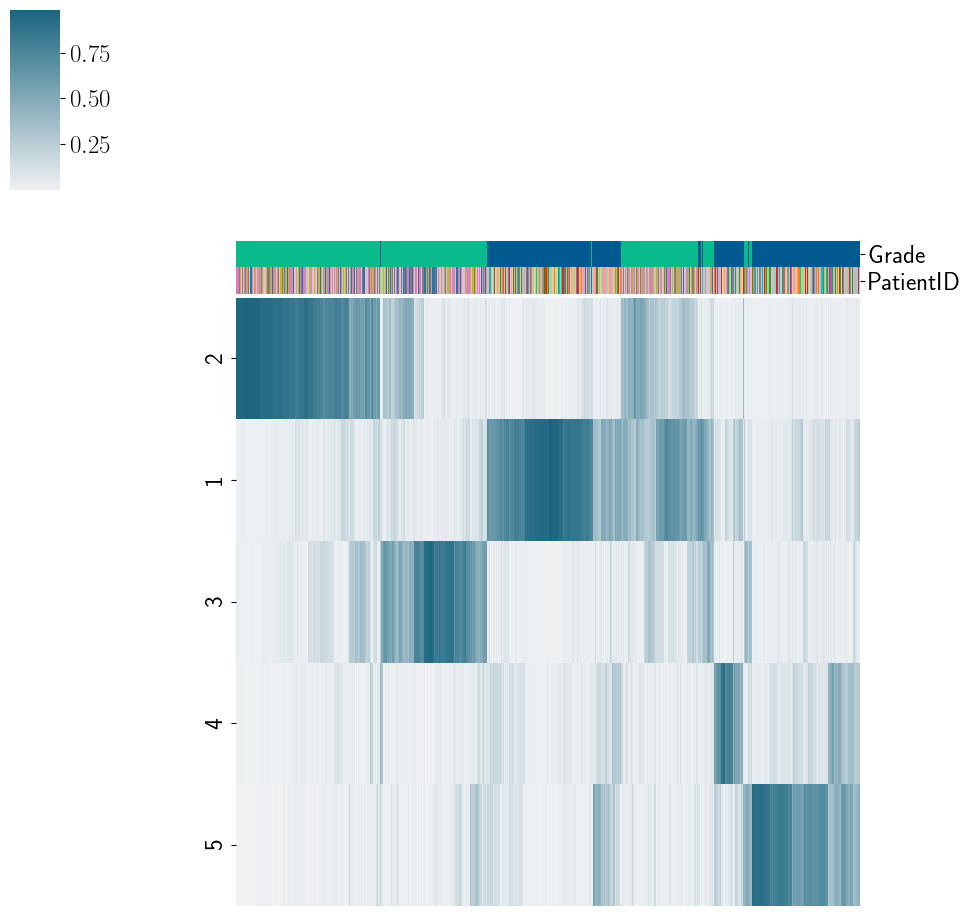

In [95]:
row_categories = ["Grade", "PatientID"]

beta_and_scale_df_a.columns += 1
# data_filt_a_val["GVHD Grade"] = data_filt_a_val["GVHD_GRADE_1"]
# # data_filt_a_val["Clusters"] = labels_allo_val

# data_filt_a_train["GVHD Grade"] = data_filt_a_train["GVHD_GRADE_1"]
# # data_filt_a_train["Clusters"] = labels_allo_train



legend_positions = np.array([[0.5,5.0, .75,.75],
          [1.6,0.32, .75,.75],
          [0.5,4.0, .75,.75],
          [1.7,1.0, .75,.75]])
        #   [0.5,1.0, .75,.75]])

legend_colors = [
    sns.color_palette(["#09BB8C", "#005A8F", "#B85000"]),
    sns.color_palette("tab20", len(np.unique(new_categorical["PatientID"]))),

    # sns.color_palette("tab20", len(np.unique(data_filt_a_train["Clusters"]))),
]

offset = [-7, -3, -2, -1, -1.5]

legend_sizes = [
    (1,1),
    (1,7),
    (1,5),
    (1,1),
    (1,2),
]

sample_idx = np.random.choice(len(beta_and_scale_df_a), 1000, replace = False).astype(int)
beta_and_scale_df_a_ds = beta_and_scale_df_a.loc[sample_idx,:].reset_index(drop = True)
new_categorical_ds = new_categorical.loc[sample_idx, :]

ax = clustermap(beta_and_scale_df_a_ds.T, new_categorical_ds, row_categories, offset, legend_positions, legend_colors, legend_sizes, "GVHD")

ax.savefig("../output_data/Basis_figures/Figure2/example_clustermap.png", dpi = 600, bbox_inches='tight')
ax.savefig("../output_data/Basis_figures/Figure2/example_clustermap.pdf", dpi = 600, bbox_inches='tight')



In [96]:
#allo needs very different parameters
n_basis = 5
n_iter = 2_000
show_basis = False
lr = 1e-2
beta_prior = 0.8
weight_decay = 1e-7
inverse_length_scale = 5
times_padded = np.linspace(-1,1,181)

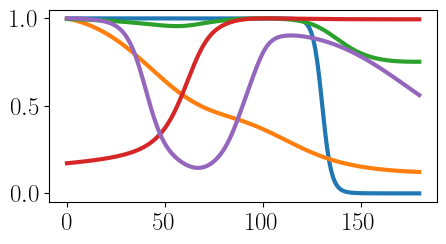

Loss: -146925.7 - Relative Error: 0.06, - Val_loss: 0.04: 100%|██████████| 2000/2000 [1:05:10<00:00,  1.96s/it]


In [97]:
trajectory_model_a_2, guide_a_2, times_a_2, samples_a_2, gene_scales_a_2, losses_a_2, rel_loss_a_2, val_loss_a_2 = compute_basis_decomposition(
gene_patterns_padded_allo_train.numpy(),#gene_patterns_masked,#gene_patterns_padded,
InferenceMode.POINT_ESTIMATE,
n_basis=n_basis,
n_iter=n_iter,
batch_size=None,
#show_basis=show_basis,
lr=lr,
beta_prior=beta_prior,
weight_decay = weight_decay,
inverse_length_scale = inverse_length_scale,
seed=3,
normalized_mode=True,
times = np.linspace(-1,1,181),
plot_every_k_epochs=100,
clone_patterns_val= gene_patterns_padded_allo_val.numpy()
) 



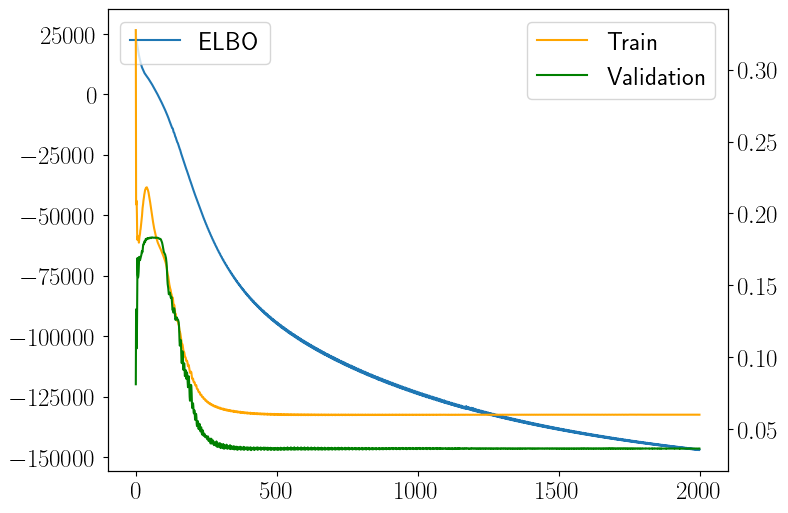

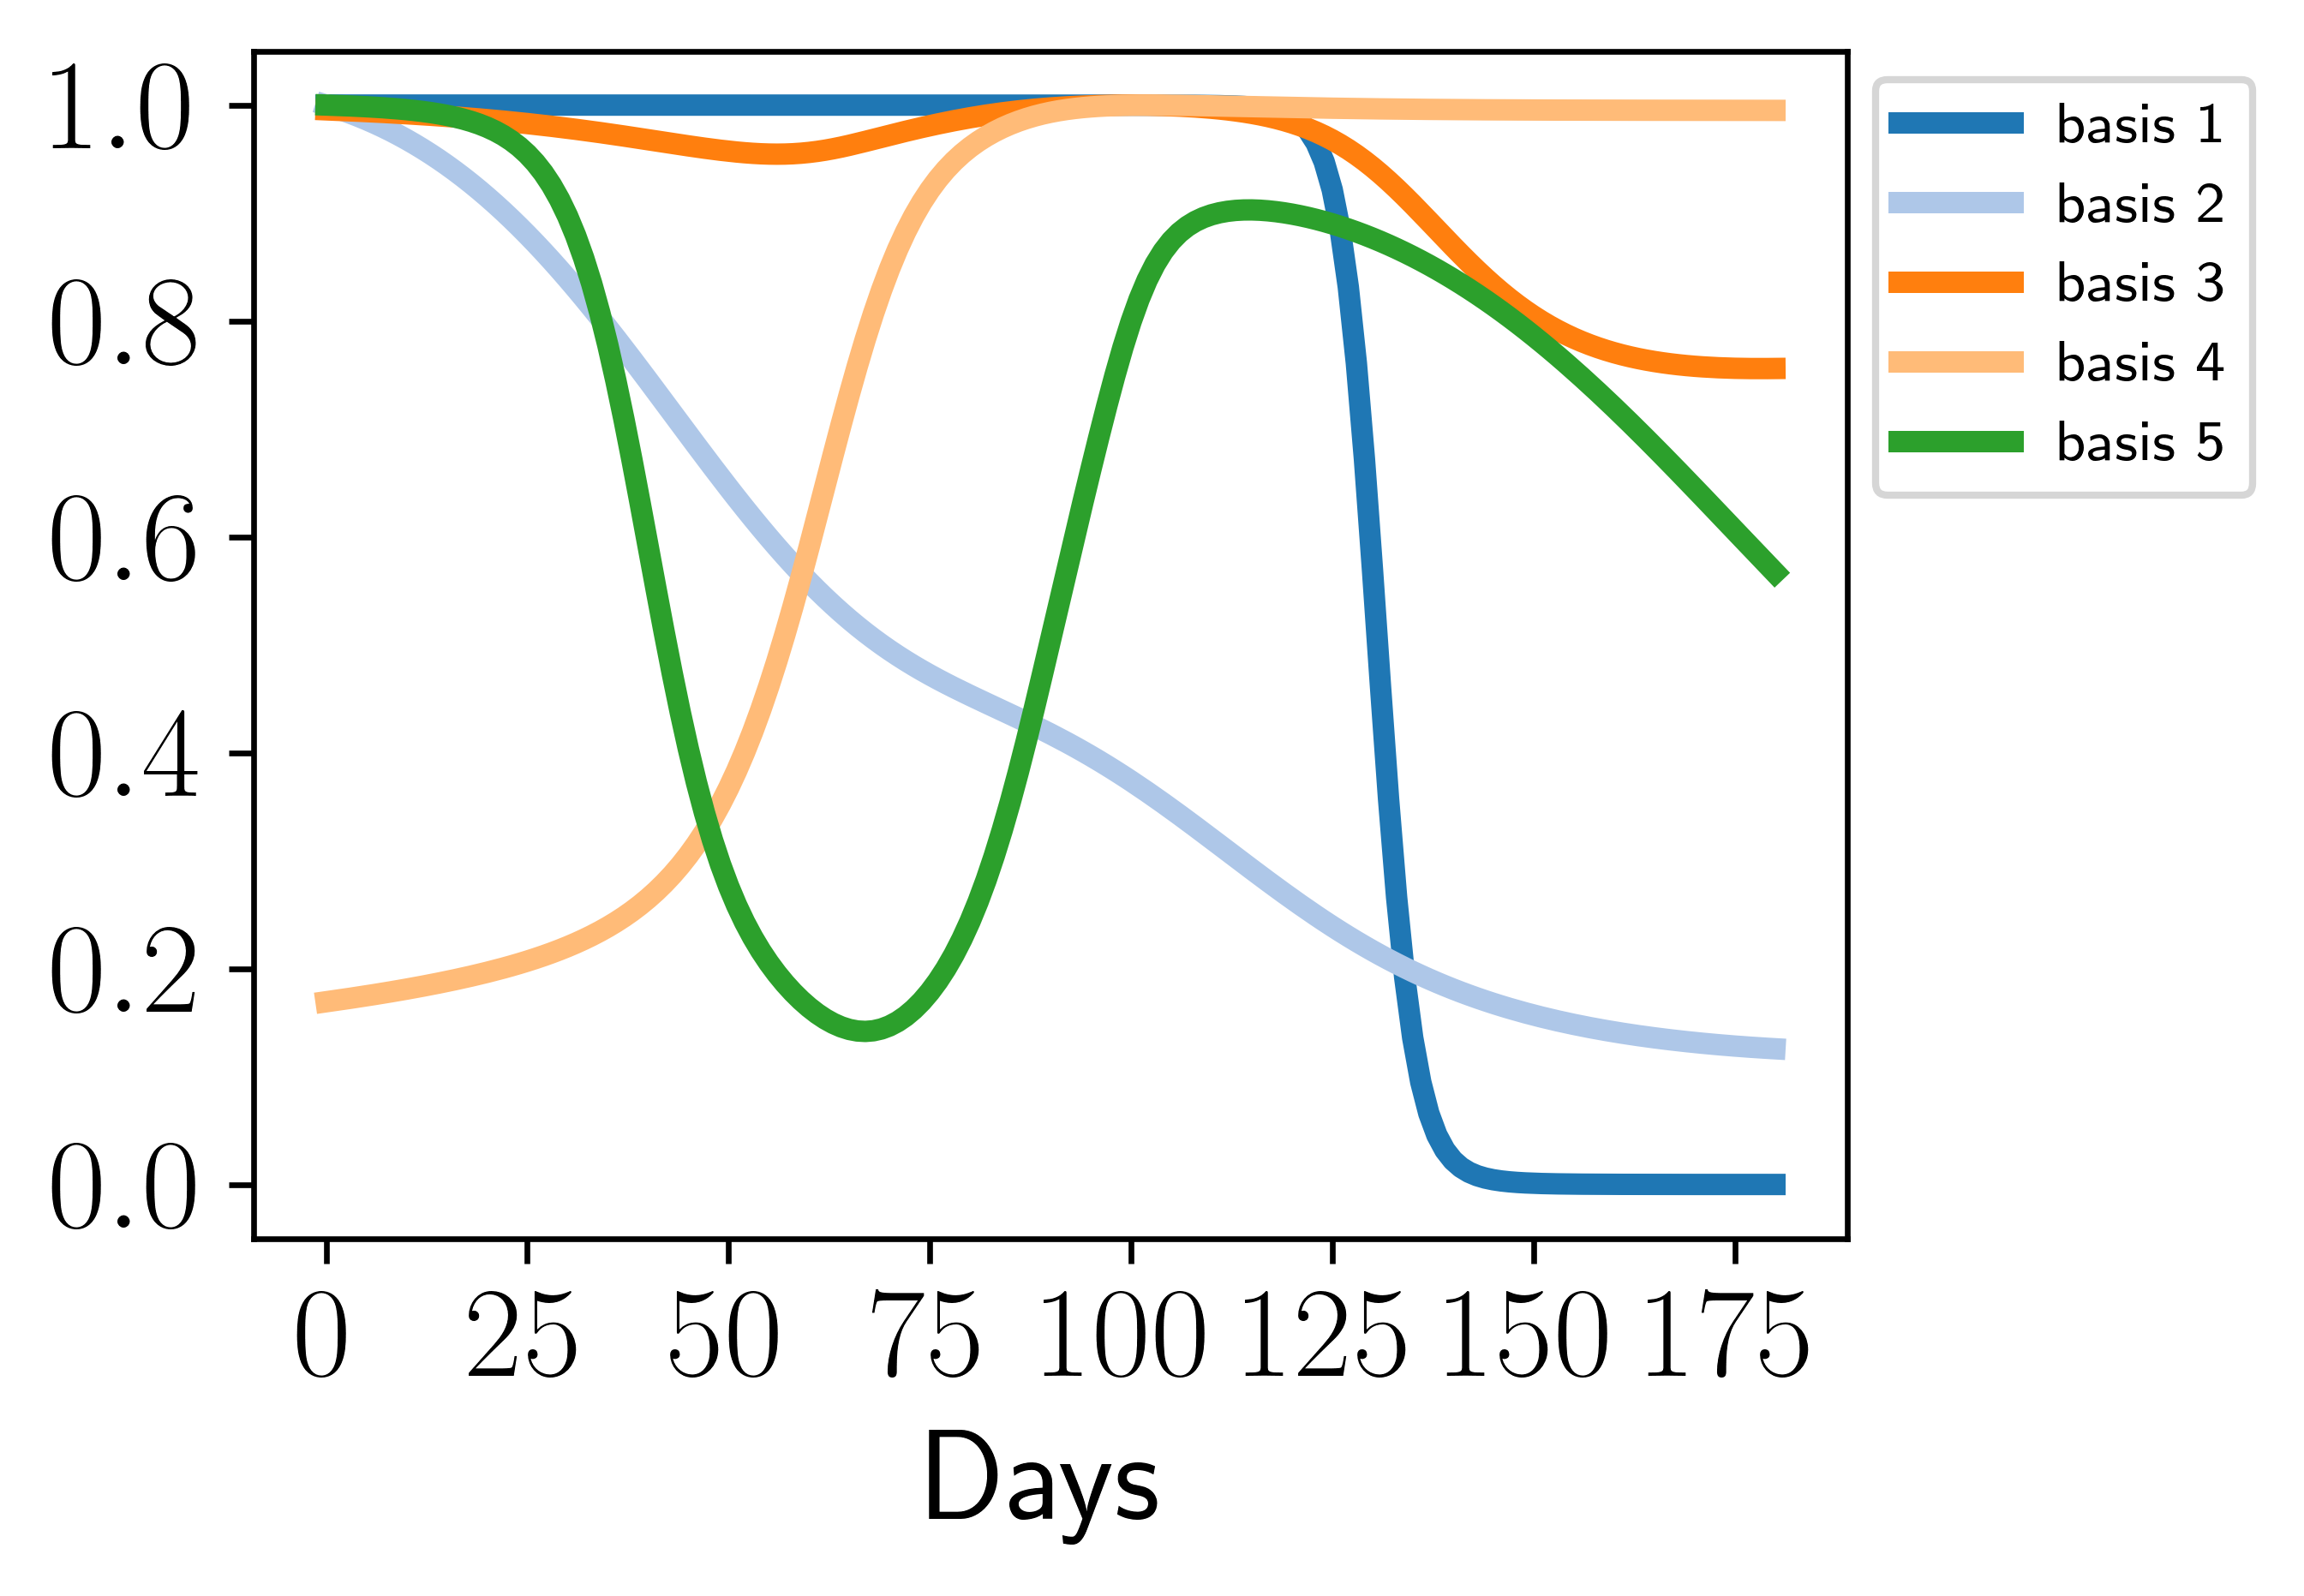

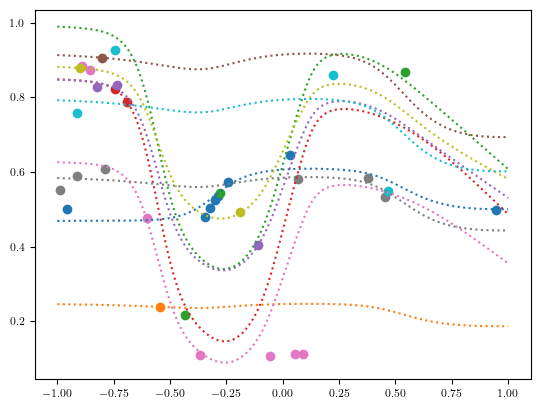

In [98]:

fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(losses_a_2)
ax2 = ax.twinx()
ax2.plot(rel_loss_a_2, color = "orange")
ax2.plot(val_loss_a_2, color = "green")
ax.legend(["ELBO"], loc = "upper left")
ax2.legend(["Train", "Validation"])

# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/SignifBasisWeightViolinPlot.png", dpi = 600)
# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/SignifBasisWeightViolinPlot.pdf")

plt.show()

basis_a_2 = get_basis(trajectory_model_a_2, guide_a_2, gene_patterns_padded_allo_train.numpy(), times_a_2)#gene_patterns_padded, times)
# torch.save(basis_a, "/Users/pressm/Documents/AziziLab/GVHD/Basis/GoodAlloResults/"+formatted_datetime+"basis_a.pth")
# basis_a = torch.load("/Users/pressm/Documents/AziziLab/GVHD/Basis/GoodAlloResults/_2024_04_29_10_34_01basis_a.pth")

colors = sns.color_palette("tab20", 20)

#basis = get_basis(trajectory_model, guide, gene_patterns, times)
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi = 600)
plt.rcParams.update({'font.size': 8})
ax = _plot_basis(basis_a_2, colors)
plt.xlabel("Days")
plt.legend(bbox_to_anchor=(1,1),loc = "upper left")

# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/SignifBasisWeightViolinPlot.png", dpi = 600)
# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/SignifBasisWeightViolinPlot.pdf")

plt.show()



# gene_scales_a.T.size()
# gene_patterns[0].size()
reconstruction = samples_a_2['_RETURN']['mean']
original = samples_a_2['obs']['mean']
# test = gene_scales_a.T*reconstruction[0]

m = 10
palette = sns.color_palette(n_colors=m)
for i in range(m):
    idx = np.random.randint(0,len(gene_patterns_padded_allo_train))
    plt.scatter(times_padded, gene_patterns_padded_allo_train[idx,:].detach().numpy(), color = palette[i])
    # plt.plot(times, gene_patterns[0,idx,:].detach().numpy(), color = palette[i])
    plt.plot(times_padded, reconstruction.numpy()[idx,:], ls = ':', color = palette[i])
# plt.ylim([-0.5,10])

# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/SignifBasisWeightViolinPlot.png", dpi = 600)
# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/SignifBasisWeightViolinPlot.pdf")

plt.show()



In [99]:
clear_val_params()

adam = pyro.optim.ClippedAdam({"lr": .01})#Adam({"lr": lr})
elbo = Trace_ELBO()
    
model_val_2 = BasisDecomposition_Evaluate(
            trajectory_model_a_2._last_basis.detach(),#torch.Tensor(np.array(my_basis).T),
            beta_prior=beta_prior,
            normalized_mode = True
            
        )
guide_val_2 = get_inference_guide(model_val_2, InferenceMode.POINT_ESTIMATE)
svi_val_2 = SVI(model_val_2, guide_val_2, adam, loss=elbo)
val_loss_2 = []
loss_val_2 = 0
for _ in range(1000):
    loss_val_2 = svi_val_2.step(torch.FloatTensor(times_padded), torch.FloatTensor(gene_patterns_padded_allo_val.numpy()))
    reconstruction_val_2 = ((model_val_2._last_patterns - gene_patterns_padded_allo_val) ** 2).nanmean().item()
    val_loss_2.append(reconstruction_val_2)


plt.plot(val_loss)


samples = []
predictive = Predictive(
        model_val_2, guide=guide_val_2, num_samples=10, return_sites=("beta_val","_RETURN",  "obs_val")
    )
samples_2 = predictive(times_a_2, gene_patterns_padded_allo_val)#, None)
# clone_patterns_mean = torch.FloatTensor(gene_patterns_padded_allo_val.numpy()).nanmean(axis = (1), keepdim=True) #clone_patterns_val.nanmean(axis=(1), keepdim=True)
# samples["_RETURN"] *= clone_patterns_mean
clone_scales = model_val_2.gene_scales #* clone_patterns_mean.squeeze(-1)
samples_2 = summary(samples_2)


TypeError: BasisDecomposition_Evaluate.__init__() missing 1 required positional argument: 'n_clones'

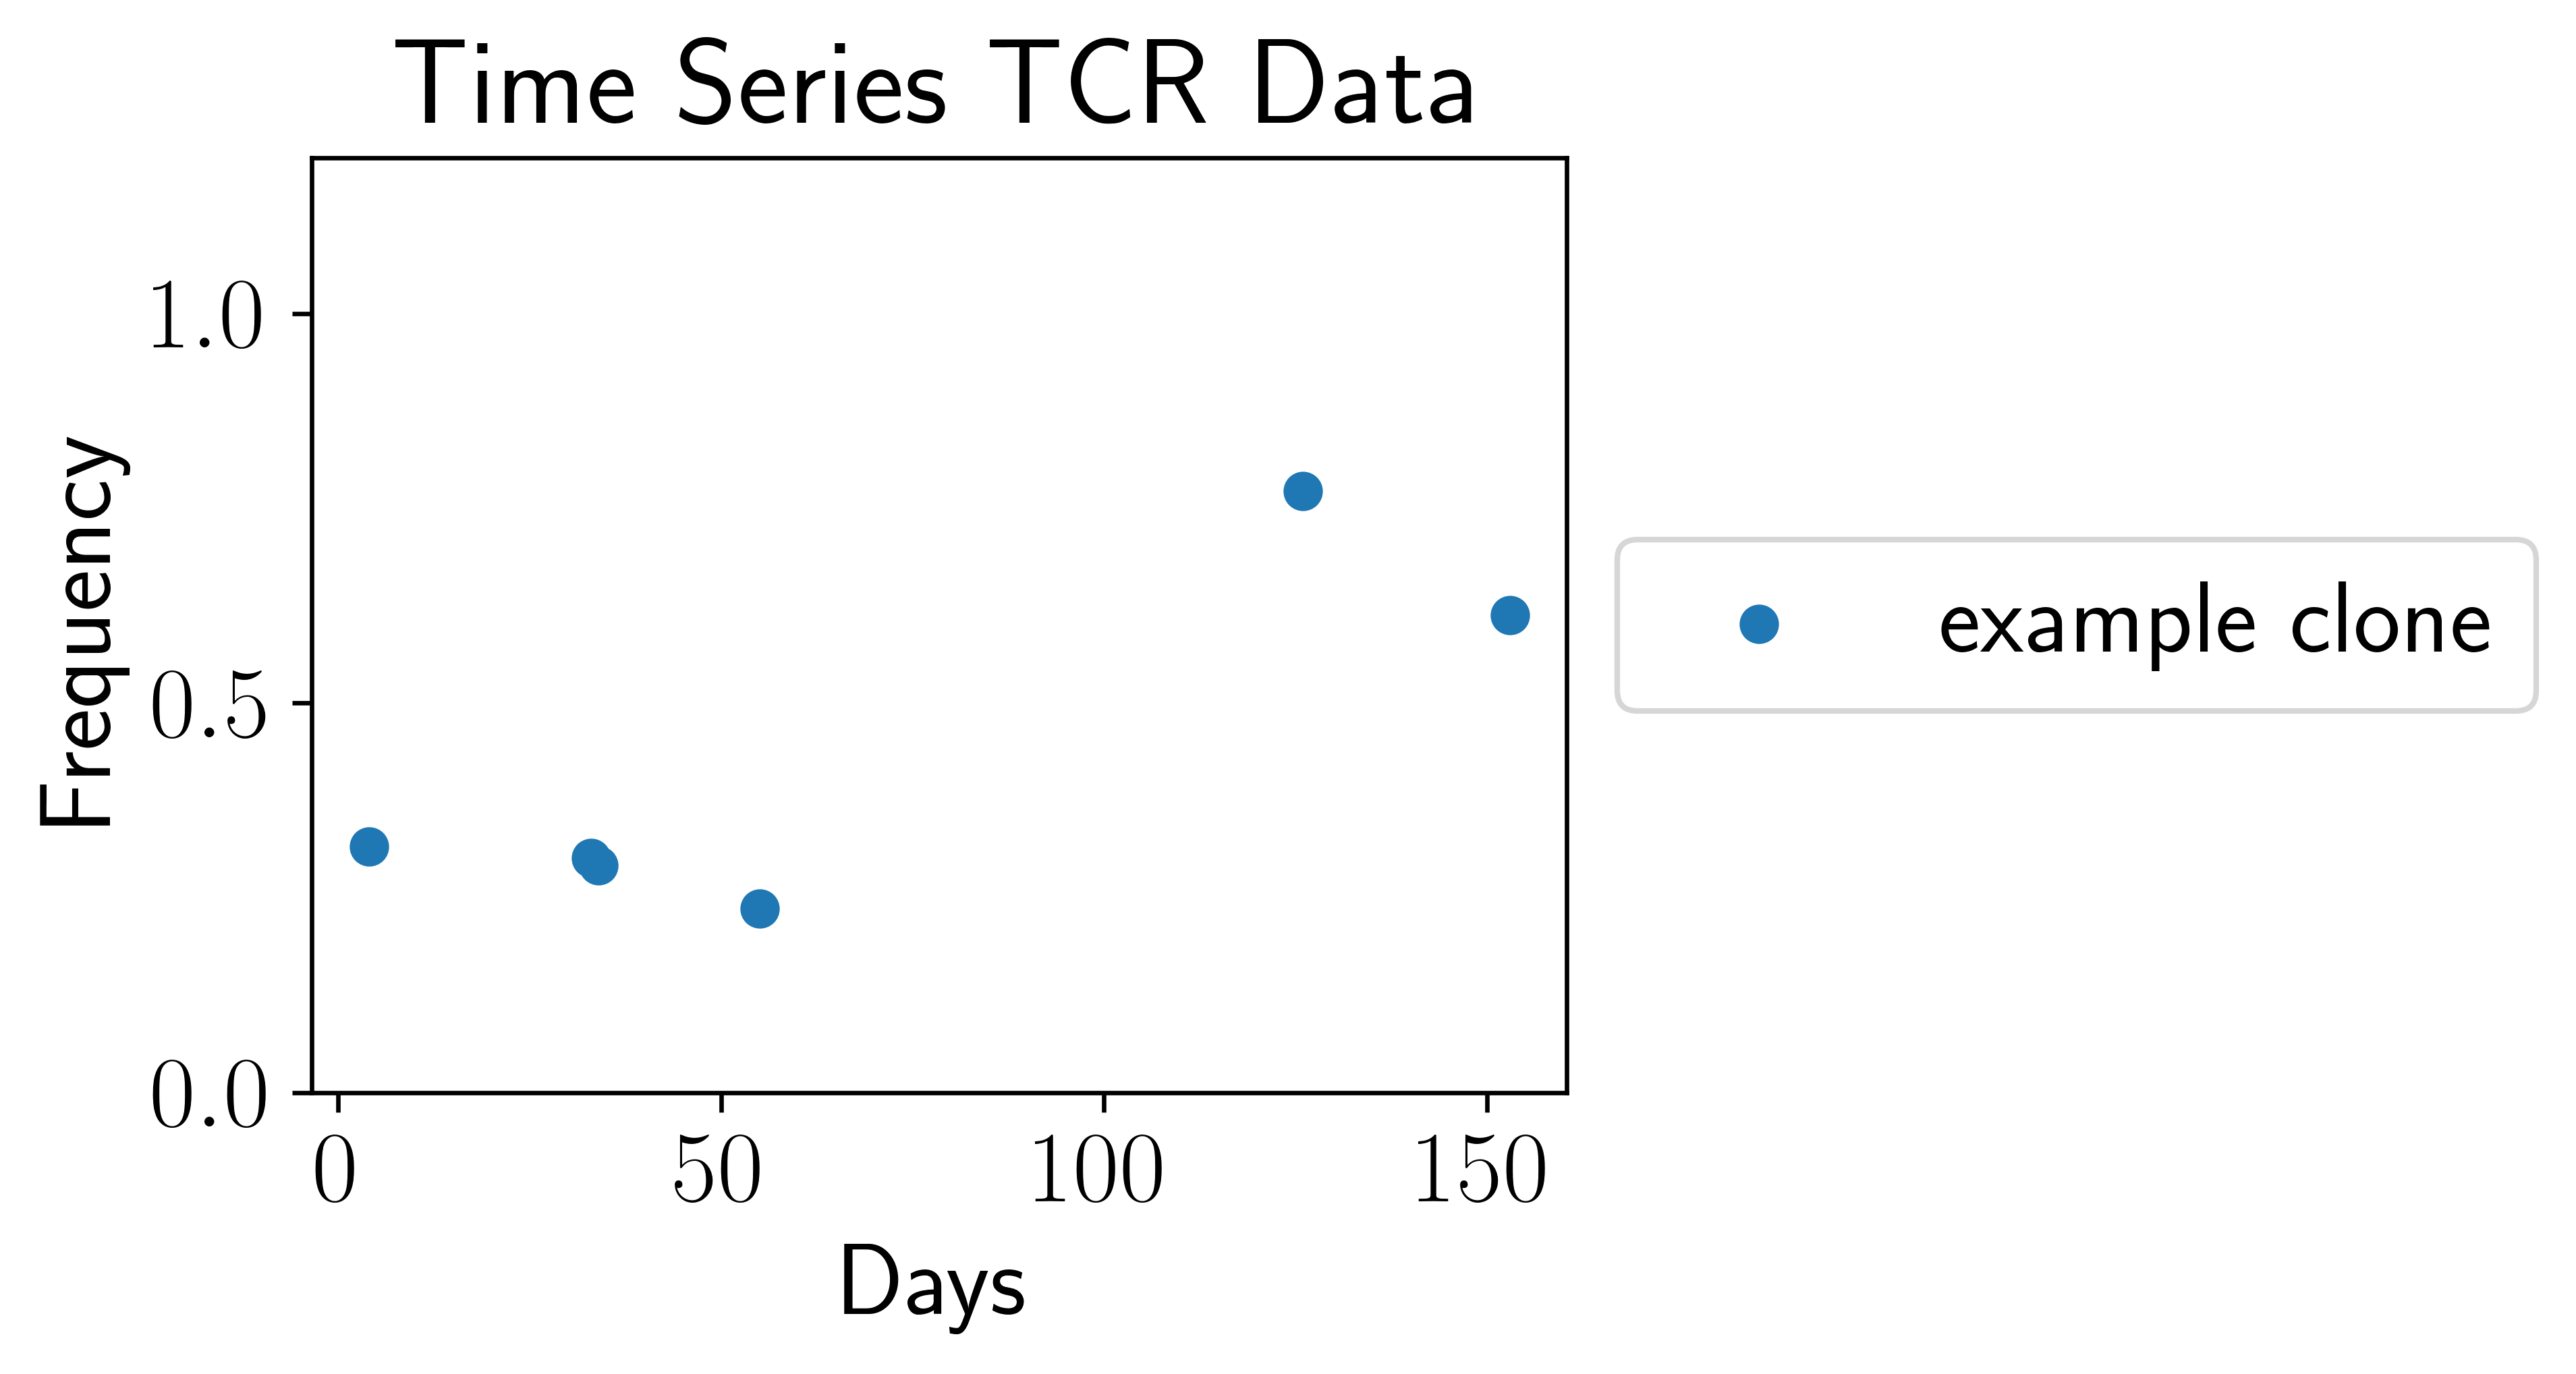

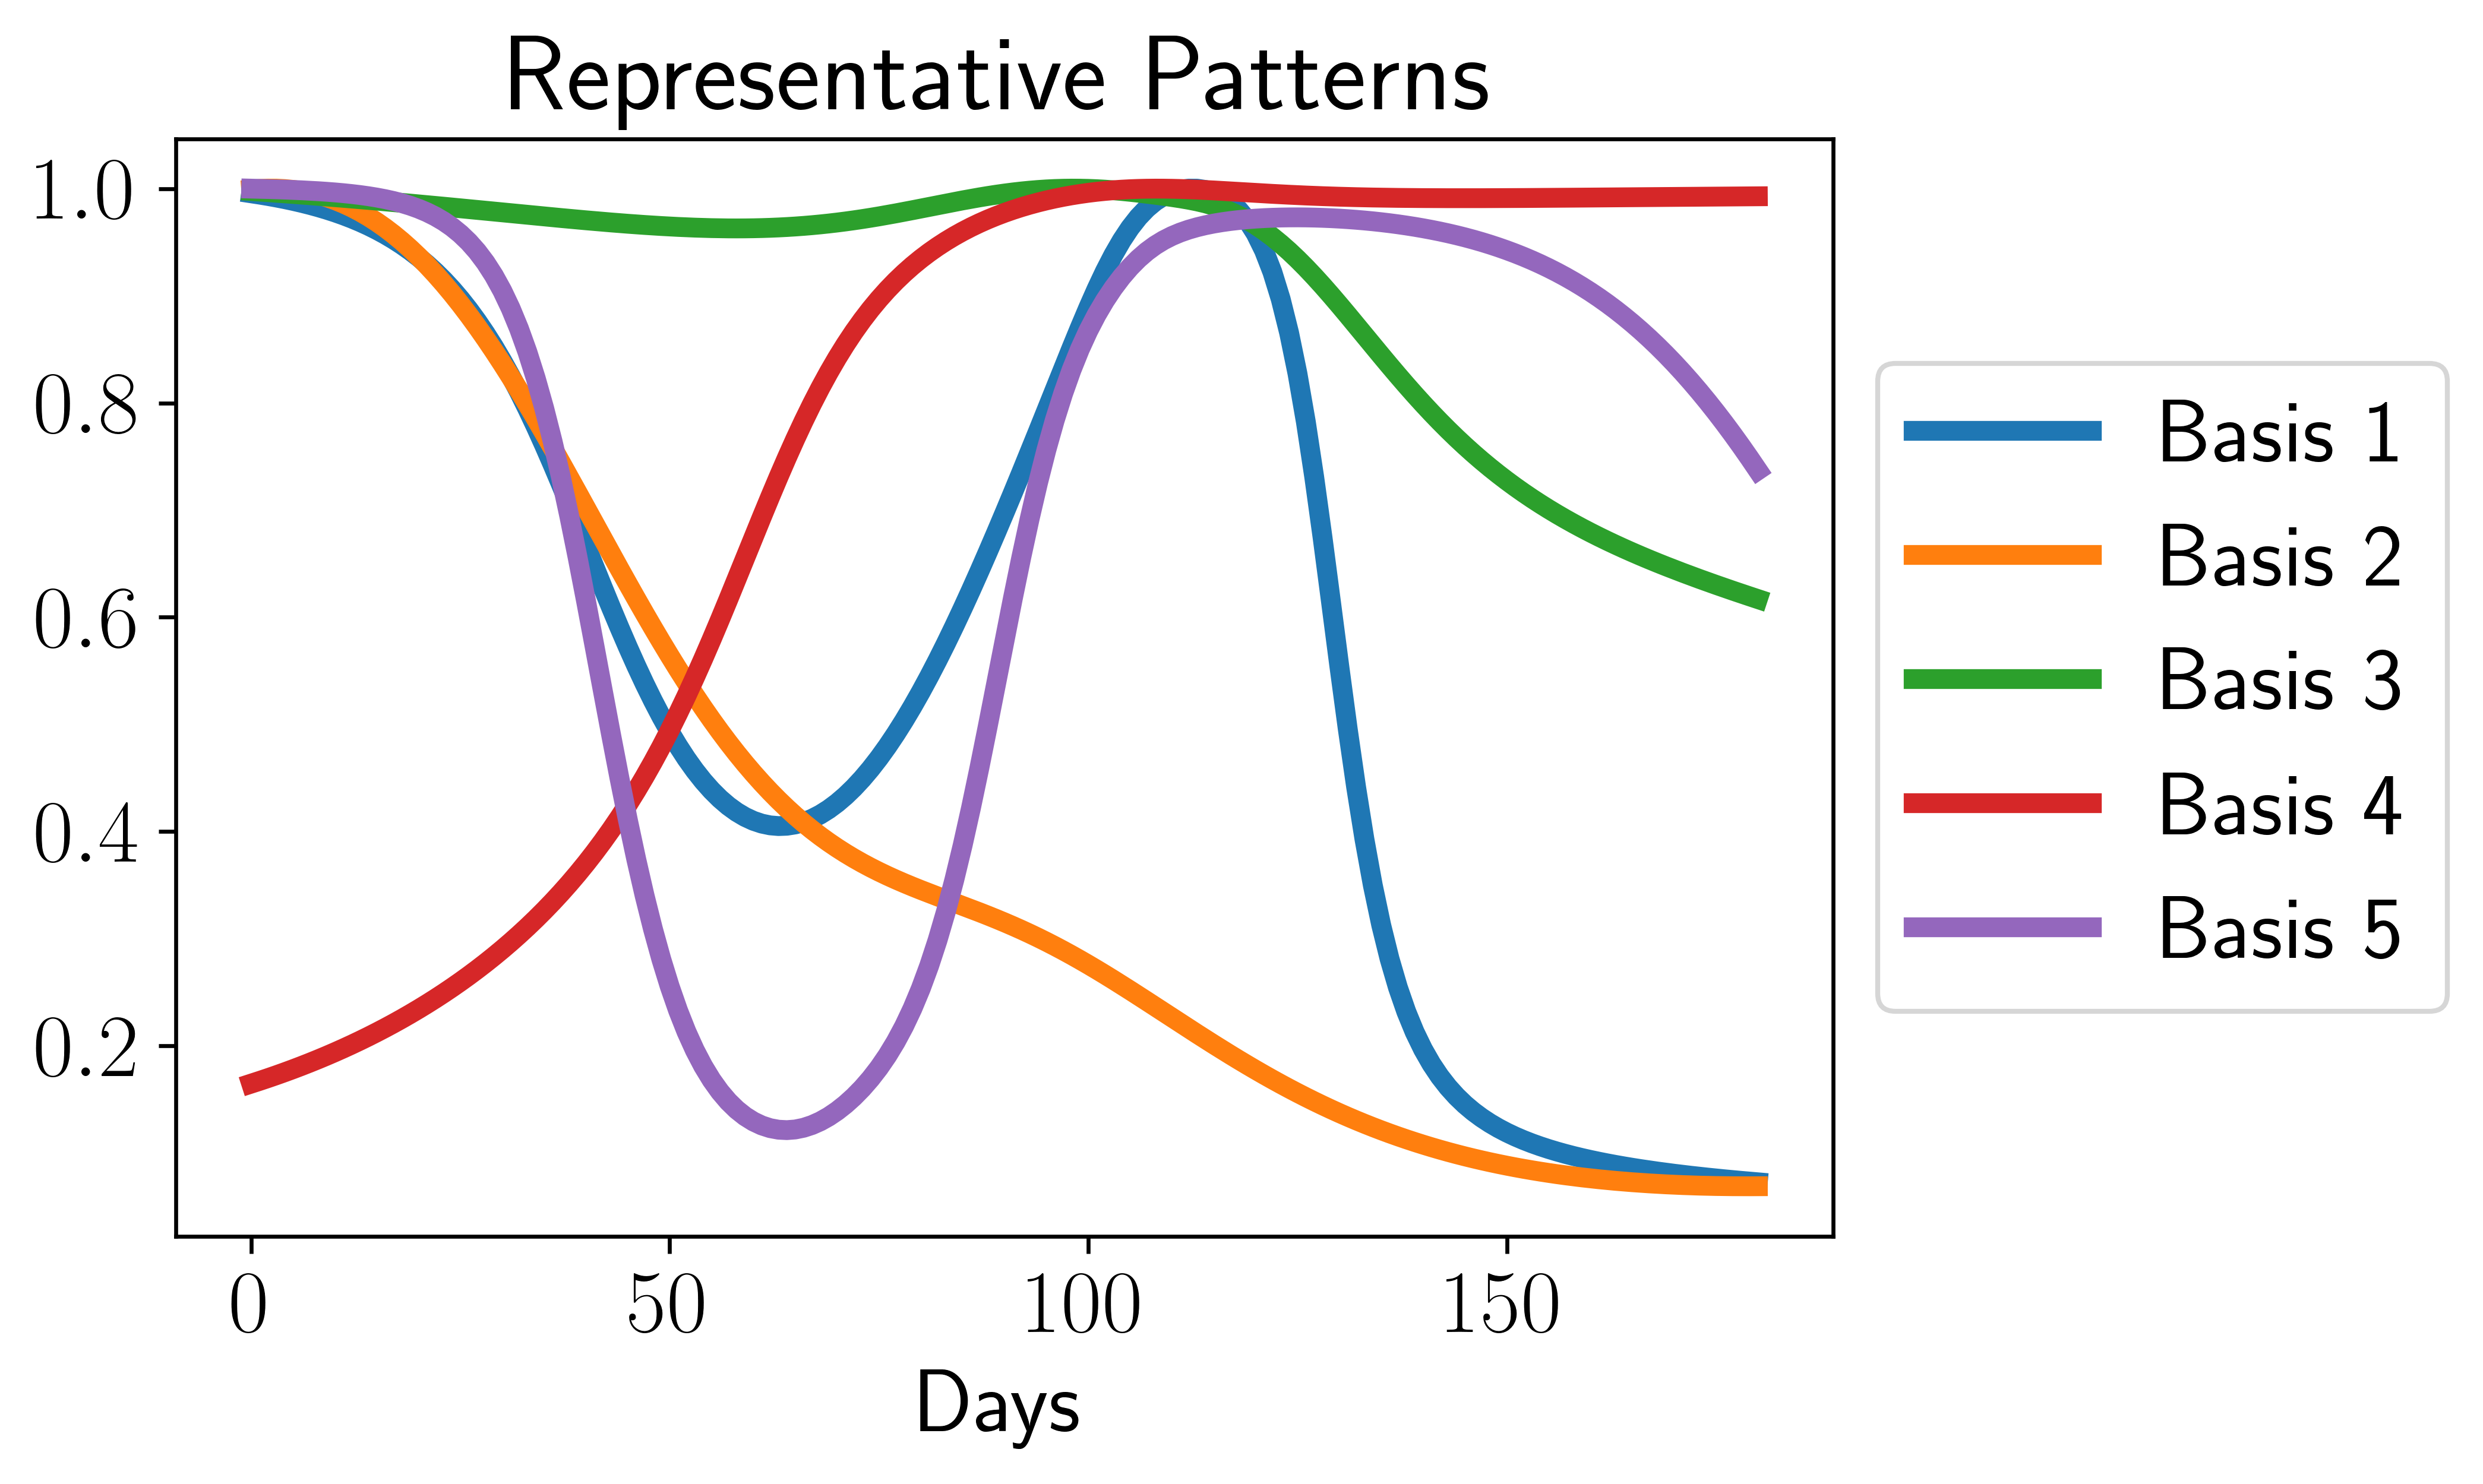

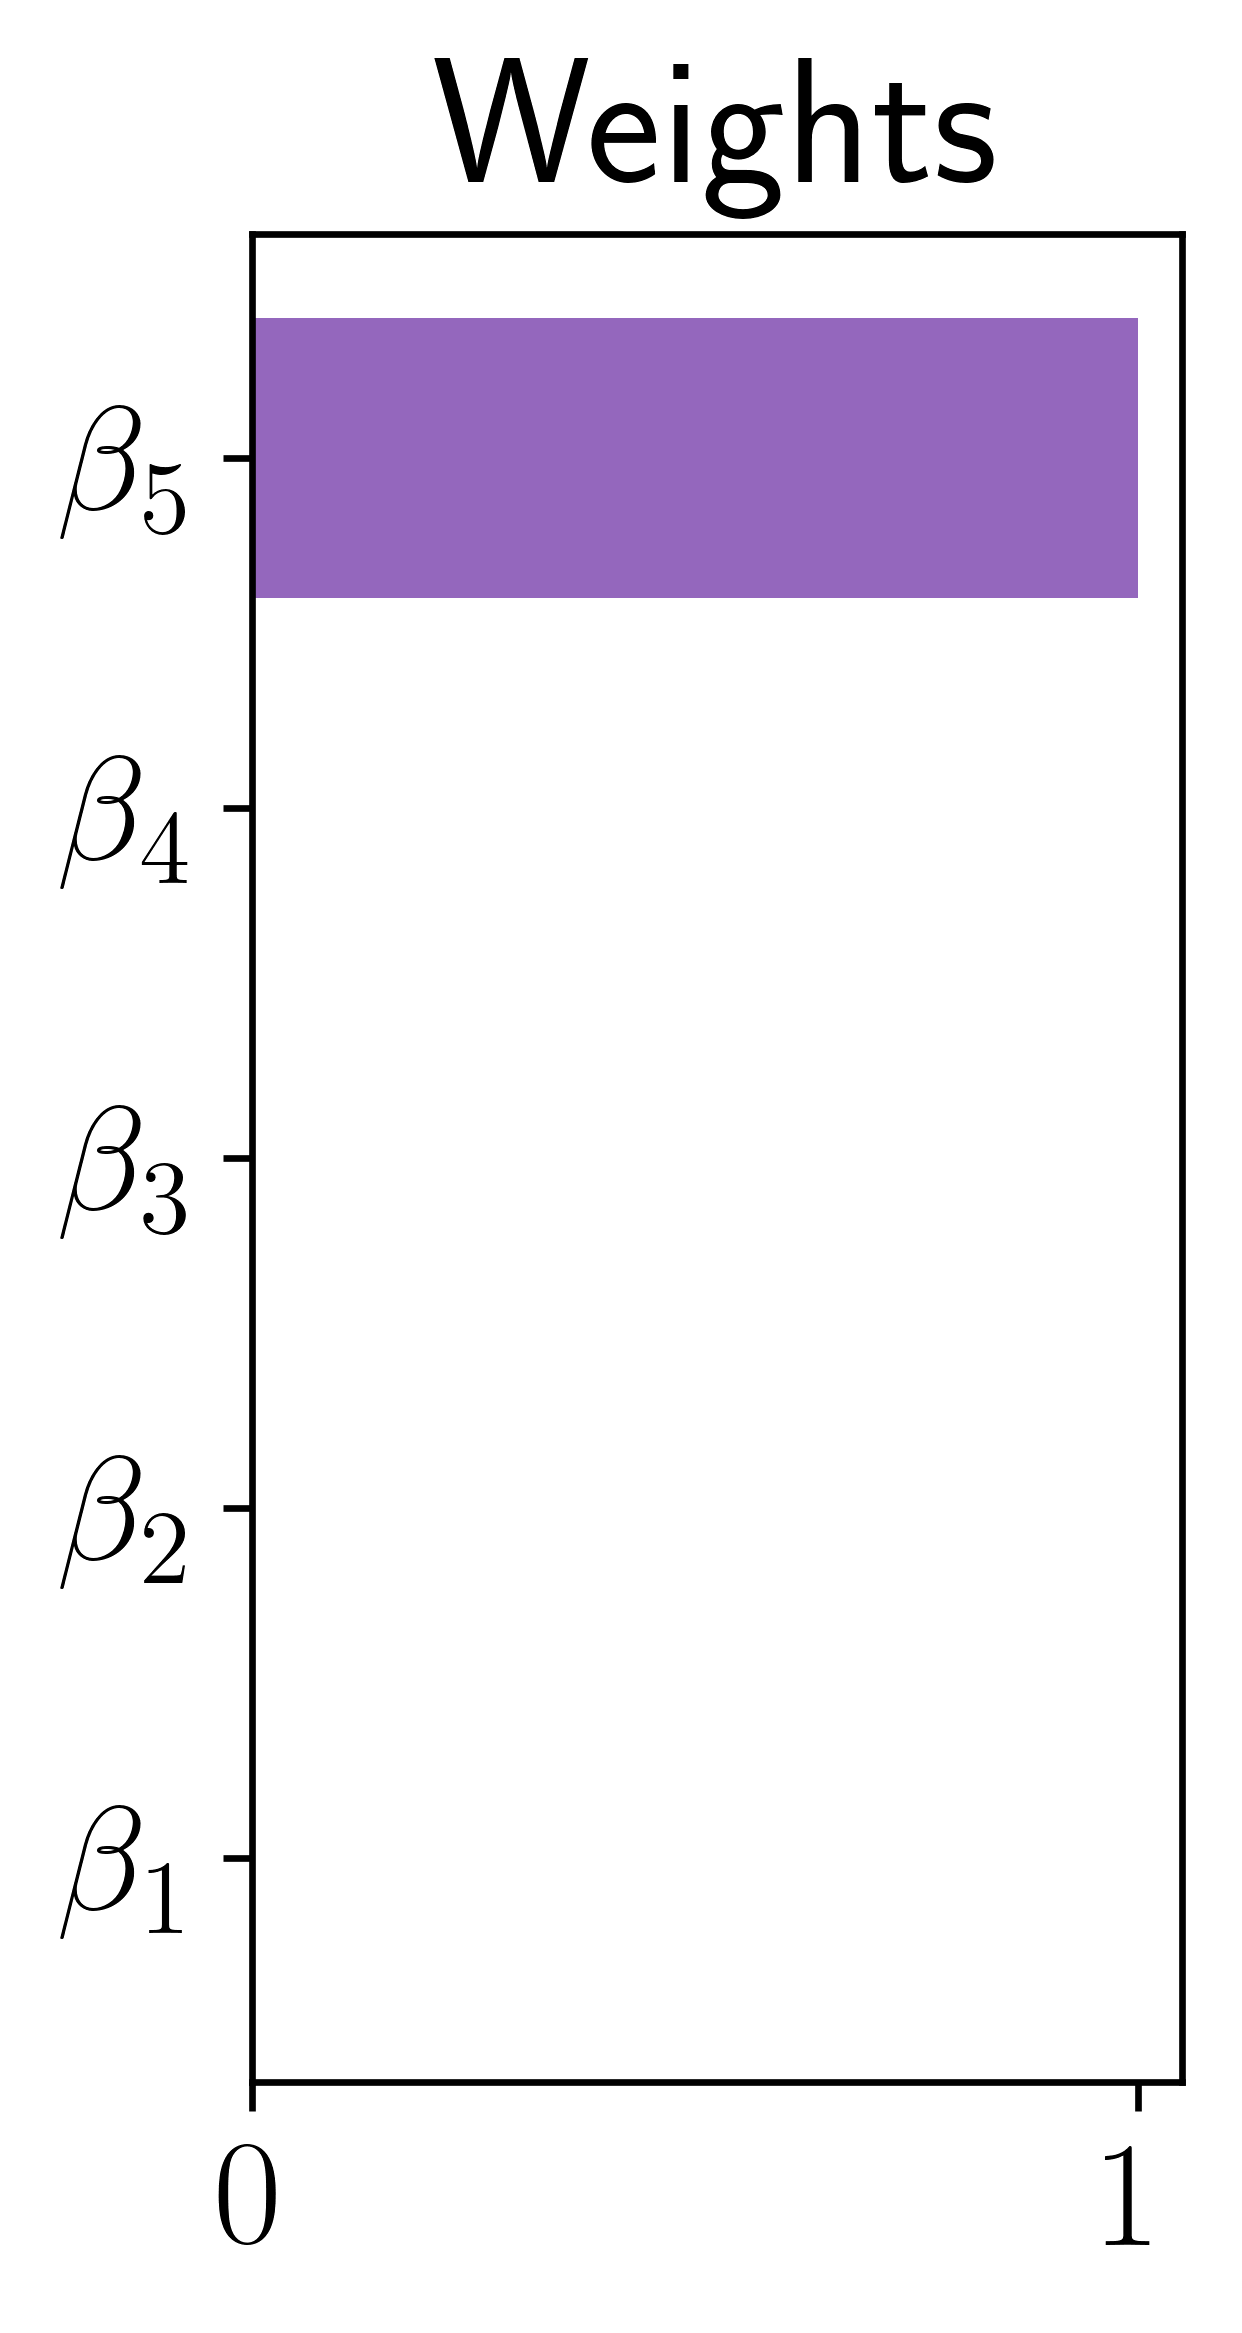

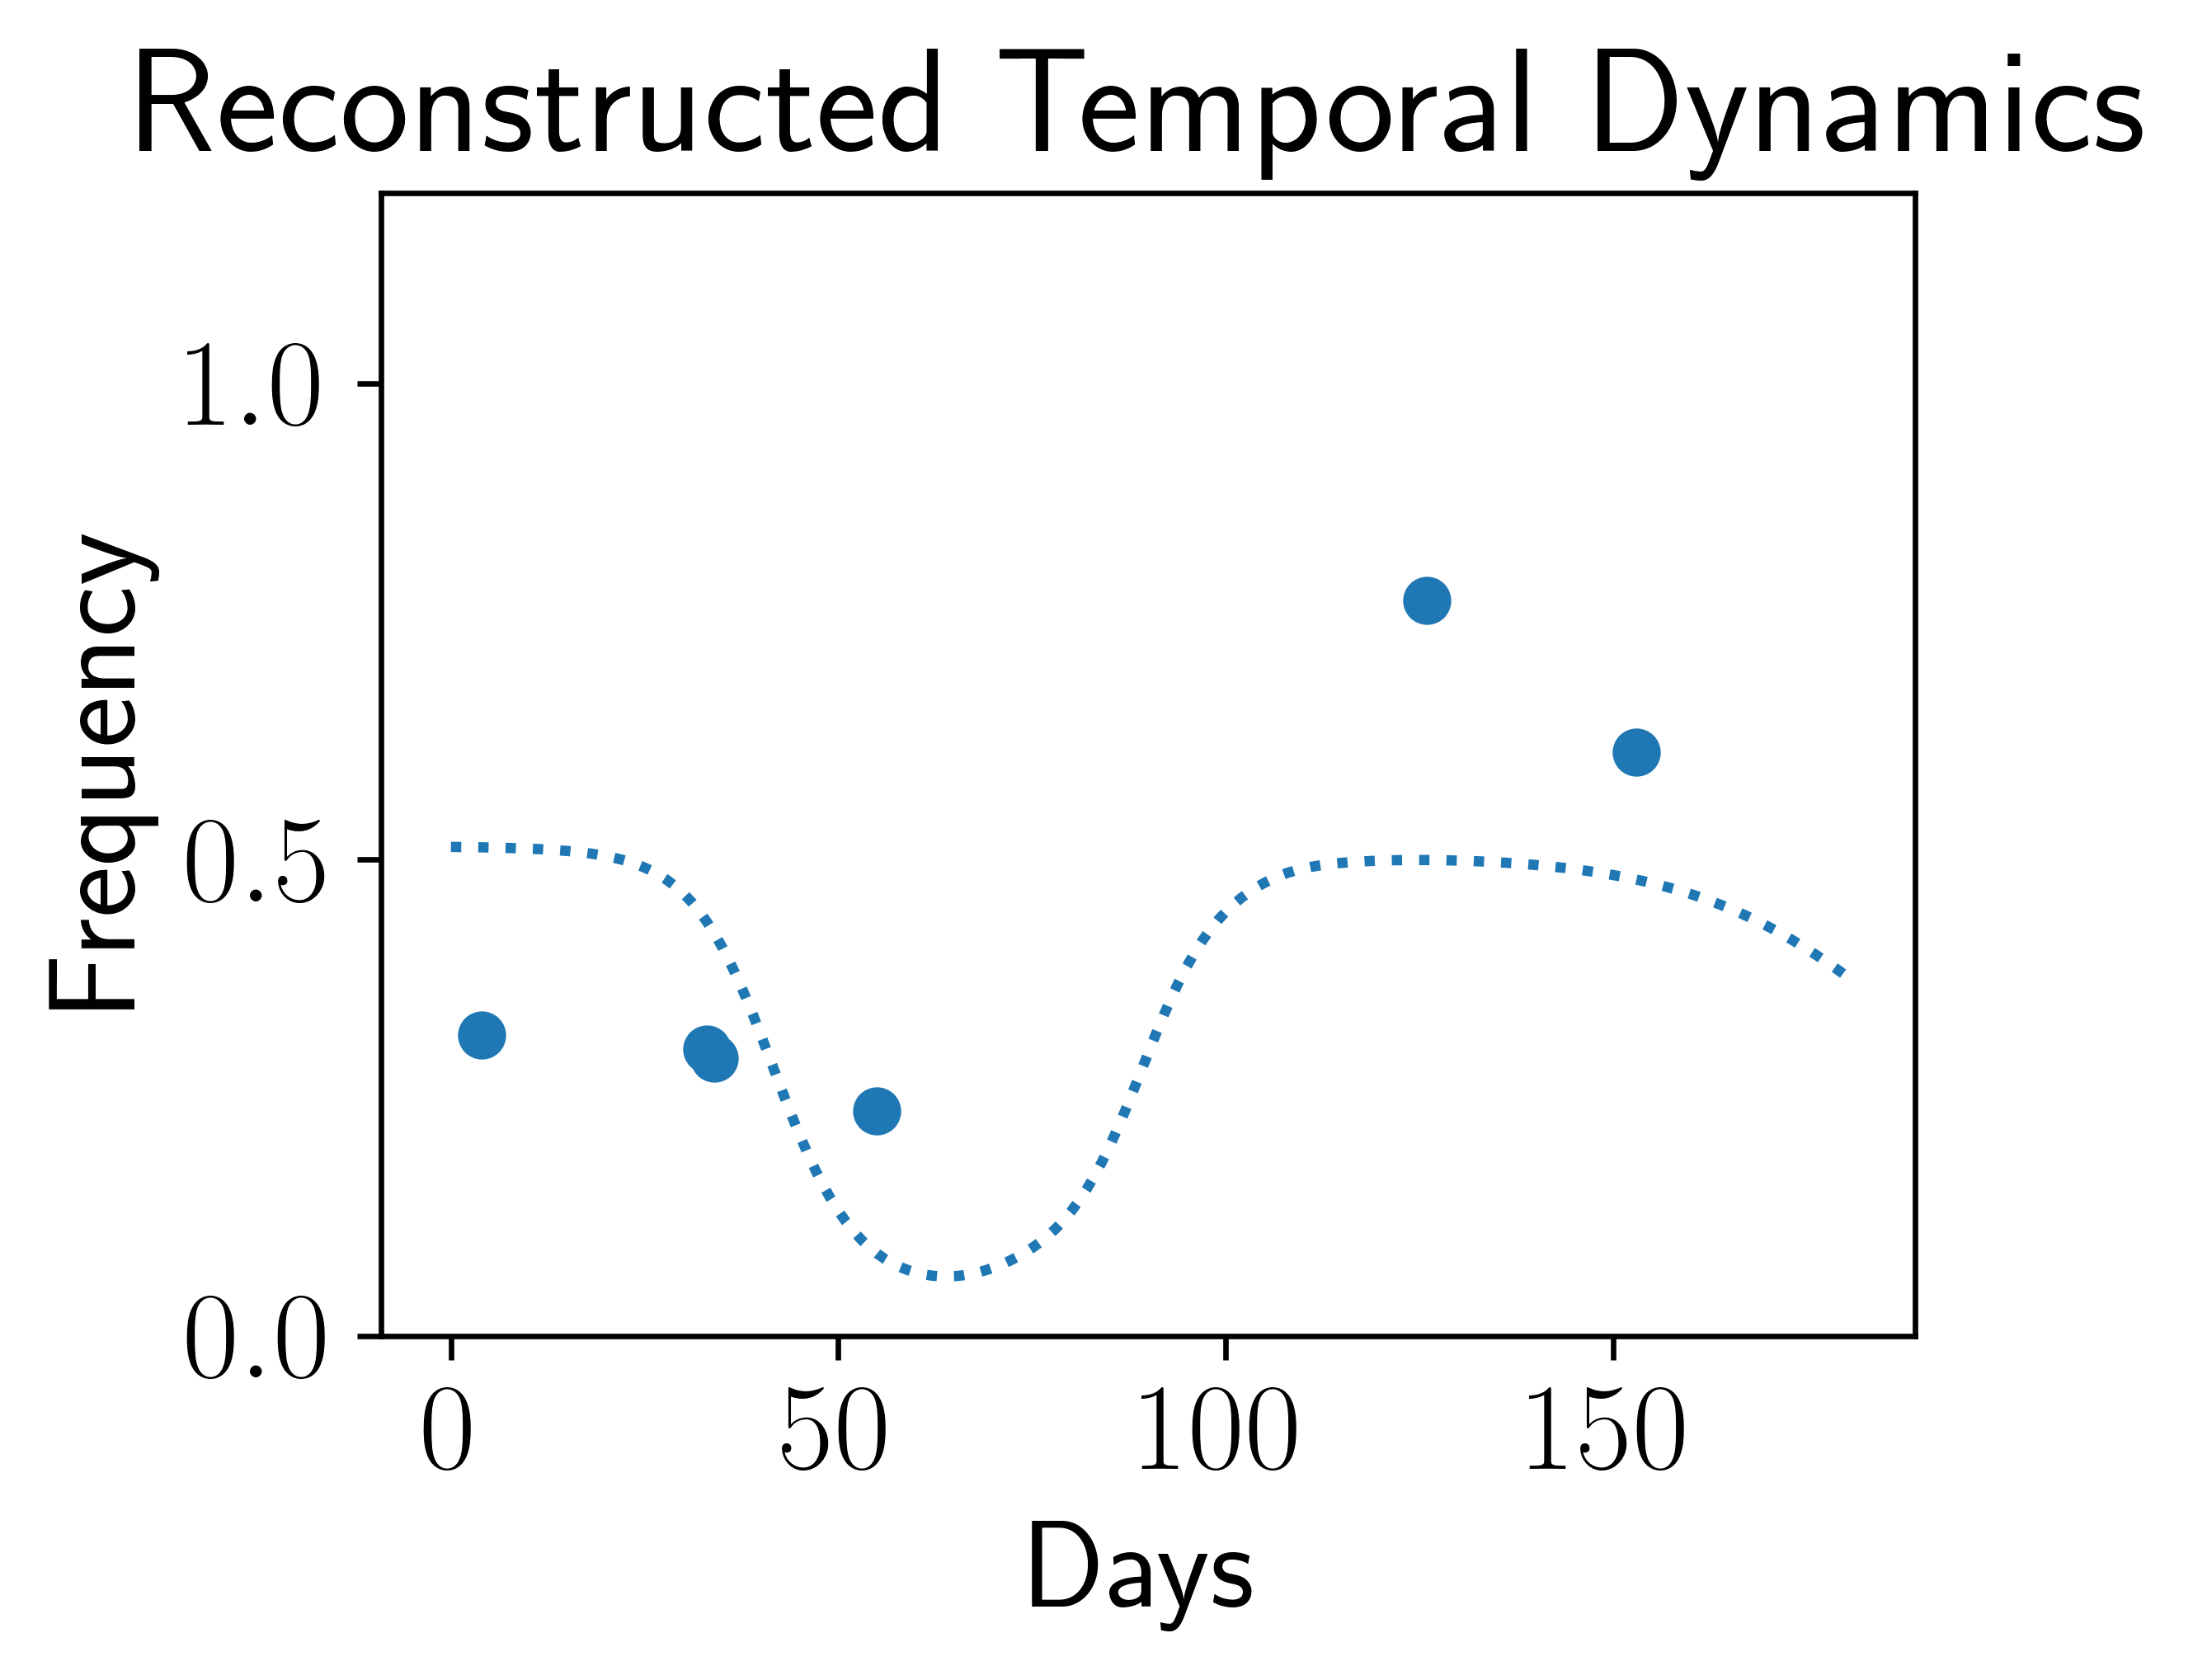

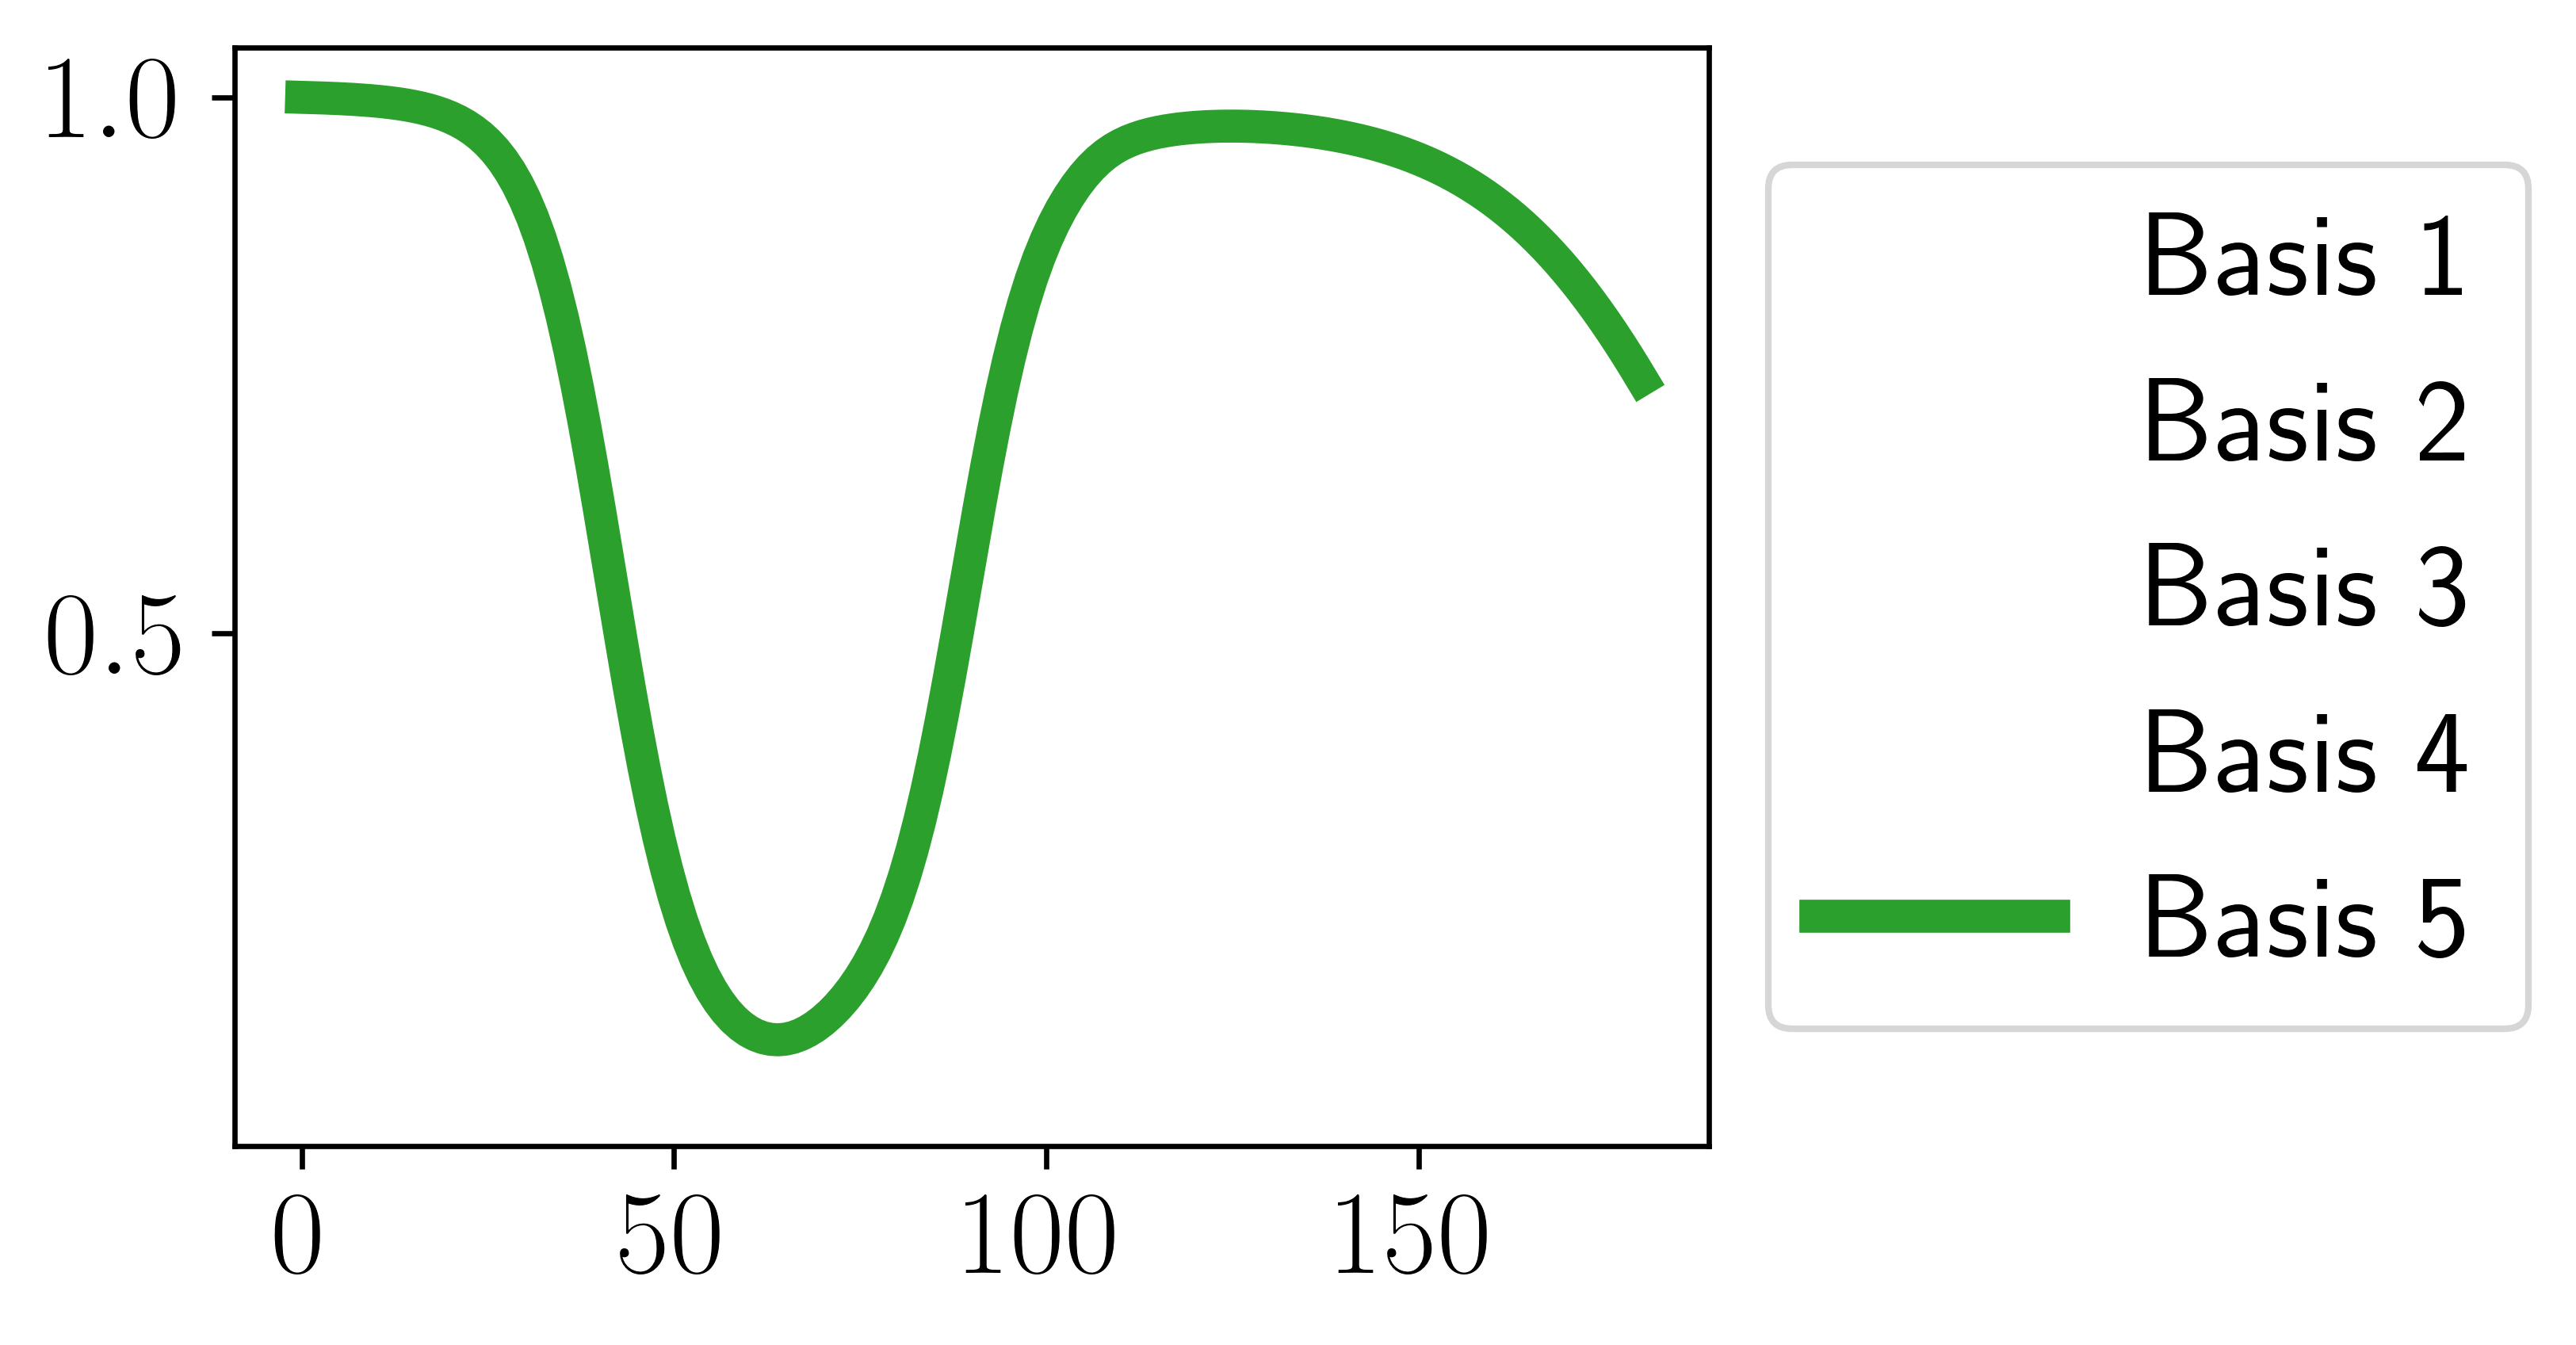

In [ ]:
# gene_scales_a.T.size()
# gene_patterns[0].size()
reconstruction = samples_a_2['_RETURN']['mean']
reconstruction_std = samples_a_2["_RETURN"]["std"]
reconstruction_q05 = samples_a_2['_RETURN']['quantile05']
reconstruction_q95 = samples_a_2['_RETURN']['quantile95']
original = samples_a_2['obs']['mean']
# test = gene_scales_a.T*reconstruction[0]


plt.rcParams.update({'font.size': 18, "text.usetex":True })

m = 1
palette = sns.color_palette(n_colors = 1)[0]
idx = 0
fig, ax = plt.subplots(1,1, figsize = (4,3), dpi = 600)
idx = np.random.randint(0,len(gene_patterns_padded_allo_train))
ax.scatter(np.arange(0,181), gene_patterns_padded_allo_train[idx,:].detach().numpy(), color = palette)
ax.set_xlabel("Days")
ax.set_ylabel("Frequency")
ax.set_ylim([0,1.2])
ax.set_title("Time Series TCR Data")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ["example clone"])
# plt.ylim([-0.5,10])
# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/example_sim_sample.png", dpi = 600)
# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/example_sim_sample.pdf", dpi = 600)
plt.show()

sample_beta = samples_a_2["beta"]["mean"].squeeze()[idx,:]

fig, ax = plt.subplots(1,1, figsize = (6,4), dpi = 600)

for i in range(basis_a_2.shape[-1]):
    ax.plot(basis_a_2[:,i], linewidth = 4, color = sns.color_palette("tab10",n_colors=n_basis)[i])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ["Basis {}".format(x) for x in range(1,n_basis+1)])
    
ax.set_title("Representative Patterns")
ax.set_xlabel("Days")

# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/example_basis.png", dpi = 600)
# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/example_basis.pdf", dpi = 600)
plt.show()

fig, ax = plt.subplots(1,1, figsize = (2,4), dpi = 600)
ax.barh(y = np.arange(1,n_basis + 1), width = sample_beta, color = sns.color_palette("tab10",n_colors=n_basis))
ax.set_yticks(np.arange(1,n_basis+1))
ax.set_yticklabels(["$\\beta_{"+str(x)+"}$" for x in range(1,n_basis+1)])
ax.set_title("Weights")

# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/example_weights.png", dpi = 600)
# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/example_weights.pdf", dpi = 600)
plt.show()


fig, ax = plt.subplots(1,1, figsize = (4,3), dpi = 600)
ax.scatter(np.arange(0,181), gene_patterns_padded_allo_train[idx,:].detach().numpy(), color = palette)
ax.plot(np.arange(0,181), reconstruction.numpy()[idx,:], ls = ':', color = palette)
ax.fill_between(np.arange(0,181), y1 = reconstruction.numpy()[idx,:] - reconstruction_std.numpy()[idx,:], y2 = reconstruction.numpy()[idx,:] + reconstruction_std.numpy()[idx,:], alpha = 0.2)
ax.set_xlabel("Days")
ax.set_ylabel("Frequency")
ax.set_title("Reconstructed Temporal Dynamics")
ax.set_ylim([0,1.2])
# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/example_reconstructed.png", dpi = 600)
# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/example_reconstructed.pdf", dpi = 600)
plt.show()

fig, ax = plt.subplots(1,1, figsize = (4,3), dpi = 600)
line_width = samples_a_2['beta']['mean'].squeeze()[idx,:]
line_width = line_width/line_width.max() * 5

for i in range(basis_a_2.shape[-1]):
    ax.plot(basis_a_2[:,i], linewidth = line_width[i], color = sns.color_palette("tab20",n_colors=n_basis)[i])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ["Basis {}".format(x) for x in range(1,n_basis+1)])

plt.show()

0.7556225268144208
(2, 41544)


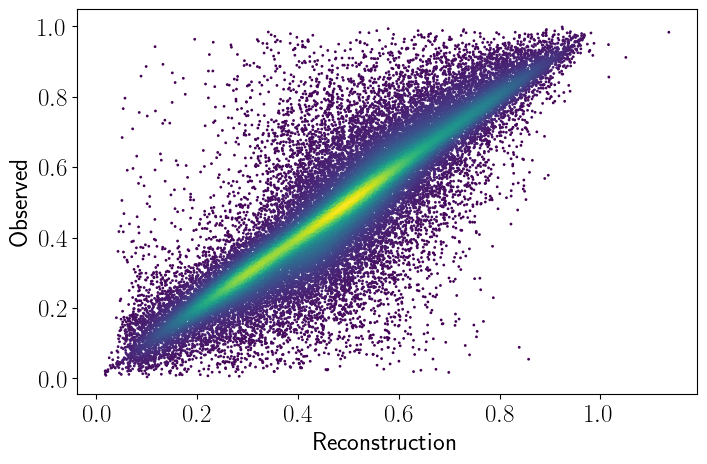

0.8658984034376211


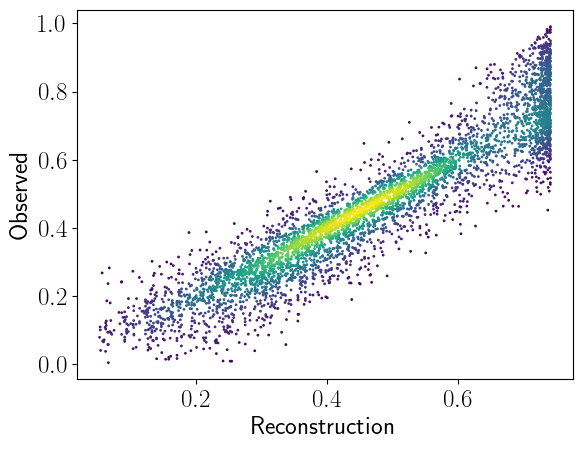

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
# gene_scales_a.T.size()
# gene_patterns[0].size()
reconstruction_val = samples_2["beta_val"]["mean"].squeeze() @ basis_a_2.T * model_val_2.gene_scales.detach().numpy()
reconstruction = samples_a_2['_RETURN']['mean']
original = samples_a_2['obs']['mean']
# test = gene_scales_a.T*reconstruction[0]

train_R2 = r2_score(gene_patterns_padded_allo_train.detach().numpy()[~torch.isnan(gene_patterns_padded_allo_train.detach())].flatten(),reconstruction.numpy()[~torch.isnan(gene_patterns_padded_allo_train.detach())].flatten())
print(train_R2)

d = np.vstack([reconstruction.numpy()[~torch.isnan(gene_patterns_padded_allo_train.detach())], gene_patterns_padded_allo_train.detach().numpy()[~torch.isnan(gene_patterns_padded_allo_train.detach())]])
kernel = gaussian_kde(d)
values = kernel(d)
print(d.shape)
fig, ax = plt.subplots(1,1, figsize = (8,5))

m = 5
ax.scatter(reconstruction.numpy()[~torch.isnan(gene_patterns_padded_allo_train.detach())], gene_patterns_padded_allo_train.detach().numpy()[~torch.isnan(gene_patterns_padded_allo_train.detach())], s = 1,
            c = values)

ax.set_ylabel("Observed")
ax.set_xlabel("Reconstruction")

# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/R2onTrain.png", dpi = 600)
# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/R2onTrain.pdf")

plt.show()


val_R2 = r2_score(gene_patterns_padded_allo_val.detach().numpy()[~torch.isnan(gene_patterns_padded_allo_val.detach())].flatten(),reconstruction_val.numpy()[~torch.isnan(gene_patterns_padded_allo_val.detach())].flatten())
print(val_R2)

d = np.vstack([reconstruction_val.numpy()[~torch.isnan(gene_patterns_padded_allo_val.detach())], gene_patterns_padded_allo_val.detach().numpy()[~torch.isnan(gene_patterns_padded_allo_val.detach())]])
kernel = gaussian_kde(d)
values = kernel(d)

m = 5
plt.scatter(reconstruction_val.numpy()[~torch.isnan(gene_patterns_padded_allo_val.detach())], gene_patterns_padded_allo_val.detach().numpy()[~torch.isnan(gene_patterns_padded_allo_val.detach())], s = 1,
            c = values)

plt.ylabel("Observed")
plt.xlabel("Reconstruction")

# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/R2onVal.png", dpi = 600)
# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/R2onVal.pdf")

plt.show()

-0.03710733762071605


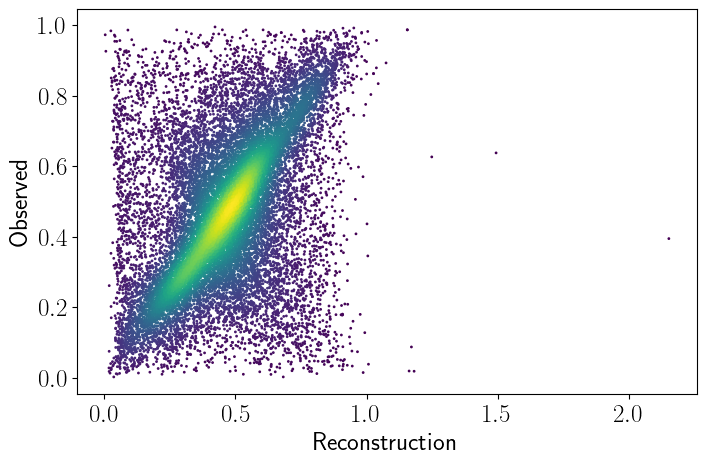

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
# gene_scales_a.T.size()
# gene_patterns[0].size()
reconstruction_val = samples_2["beta_val"]["mean"].squeeze() @ basis_a_2.T * model_val_2.gene_scales.detach().numpy()
reconstruction = samples_a_2['_RETURN']['mean']
original = samples_a_2['obs']['mean']
# test = gene_scales_a.T*reconstruction[0]

train_R2 = r2_score(gt_train.numpy().flatten(),reconstruction.numpy().flatten())
print(train_R2)

rand_idx = np.random.randint(0, len(reconstruction.numpy().flatten()), 20000)

d = np.vstack([reconstruction.numpy().flatten()[rand_idx], gt_train.numpy().flatten()[rand_idx]])
kernel = gaussian_kde(d)
values = kernel(d)

fig, ax = plt.subplots(1,1, figsize = (8,5))

# m = 5
ax.scatter(reconstruction.numpy().flatten()[rand_idx], gt_train.numpy().flatten()[rand_idx], s = 1,c = values)

ax.set_ylabel("Observed")
ax.set_xlabel("Reconstruction")

# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/R2OnAll.png", dpi = 600)
# plt.savefig("/Users/pressm/Documents/AziziLab/GVHD/immunoseq_r/Main_Fig/Figure2/R2OnAll.pdf")

plt.show()